In [1]:
import rps.robotarium as robotarium
from rps.utilities.transformations import *
from rps.utilities.barrier_certificates import *
from rps.utilities.misc import *
from rps.utilities.controllers import *

import numpy as np
import scipy.stats as st
import time

# Funzioni introduttive

In [2]:
#Defining the input axes
# Note: the boundaries for the control actions are the actuation constraints imposed by the physics of the robots

control_space_size = 3  # Three possible inputs for each control axis

'''Lo spazio di controllo è discretizzato su 3 possibili valori, che rappresentano le velocità di movimento del robot su un determinato asse, dato che il robot può muoversi solo sul piano
x-y (non può muoversi in altezza), rappresentano una velocità positiva, negativa o nulla su quel determinato asse. Dal punto di vista del codice ciò è codificato come:
-0.5 -> velocità lungo la direzione negativa dell'asse
0 -> nessuna velocità lungo l'asse
+0.5-> velocità lungo la direzione positiva dell'asse


Definiamo quindi lo spazio di controllo come un array di 3 elementi, che rappresentano i possibili valori che può assumere un asse di controllo, sia per l'asse delle x che per l'asse delle y'''
U_space_1 = np.array(np.linspace((-0.5),(0.5),control_space_size)) 
U_space_2 = np.array(np.linspace((-0.5),(0.5),control_space_size))


time_step = 0.033 # Robotarium time-step (from the documentation)

Nonostante per il controllo data driven non sia necessario conoscere il modello del sistema, è necessario conoscerlo per simularlo, la funzione $\bold{model\_step}$ è utilizzata
semplicemente per calcolare il prossimo stato del robot, dato lo stato attuale e l'azione che si vuole compiere, in questo caso l'azione è rappresentata da un vettore di velocità come
spiegato precedentemente. $\\$
La funzione $\bold{my\_logpdf}$ calcola il valore della pdf di una gaussiana multivariata, dato un punto $(x,y)$, la media e la covarianza della gaussiana. In questo caso specifico la covarianza
è fissata, come si può vedere successivamente nel codice, al valore: $$covar = np.diag(v), dove v = np.array([0.02, 0.02], dtype=np.float32)$$

Questo significa che la gaussiana è isotropa con varianza $0.02$ su entrambi gli assi, ovvero la covarianza è definibile come:

$$\sum = \sigma^2I$$ 

$I$ rappresenta la matrice identità, mentre $\sigma$ è la varianza scalare.

Per quanto riguarda la modellazione dell'ostacolo, l'isotropia della gaussiana implica che la varianza della distribuzione è la stessa su entrambi gli assi. Ciò significa che l'ostacolo è da considerare sferico, con la stessa estensione in tutte le direzioni, o probabilmente un quadrato (per tale motivo, successivamente, si fa anche l'assunzione che la visualizzazione degli ostacoli come dei rettangoli sia un mero artificio di visualizzazione, piuttosto che una rappresentazione fidata dell'ostacolo dato il tipo di modellazione scelta). In questo caso la funzione è utilizzata per calcolare la distanza tra il punto $(x,y)$, che rappresenta lo stato attuale del robot, e un generico ostacolo.

[Riferimento: isotropia della gaussiana](https://magic-with-latents.github.io/latent/posts/ddpms/part2/#:~:text=Isotropic%20Gaussian,-An%20isotropic%20Gaussian&text=(4)%20represents%20a%20diagonal%20matrix,Gaussian%20is%20circular%20or%20spherical)

---

In [3]:
# This function performs a "model" step using the documented dynamics
# Note: from the viewpoint of the controller the dynamics is not necesarily known
def model_step(x,velocities,time_step):
    poses = np.zeros((2,1))
    # Update pose of the robots
    poses[0] = x[0] + time_step*velocities[0]
    poses[1] = x[1] + time_step*velocities[1]
    return(poses)

# Get the value of a Gaussian pf at a given point *****?
# This function is used to evaluate the pf at a given point (x,y) given the mean and covariance of the Gaussian 
def my_logpdf(x, u, covar):
    k = len(x)  # dimension
    a = np.transpose(x - u)
    b = np.linalg.inv(covar)
    c = x - u
    d = np.matmul(a, b)
    e = np.matmul(d, c)
    numer = np.exp(-0.5 * e)
    f = (2 * np.pi)**k
    g = np.linalg.det(covar)
    denom = np.sqrt(f * g)
    pdf = numer / denom
    return pdf


# WP0
Prima di introdurre ulteriormente il codice, per supporto all'analisi del codice e delle scelte progettuali già fatte all'interno del codice fornito, e quelle compiute dal gruppo, si fa riferimento alla formalizzazione del problema di controllo effettuato nella relazione in allegato al codice del progetto. In particolare si riporta la formula semplificata la per la risoluzione del $\bold {FOC}$ nel caso in cui la $q_{0:N}$ è uniforme:
$${p^{(u)}_{k|k-1}}^* = \frac{exp(\mathbb{E_{p_{k+1|k}^{(x)}}}[ln(p_{k+1|k}^{(x)})+ \overline c_{k}(X_k)])}{\sum_{u_k}exp(\mathbb{E_{p_{k+1|k}^{(x)}}}[ln(p_{k+1|k}^{(x)})+ \overline c_{k}(X_k)])} \space \space \bold{(1)}$$
e ci riconduciamo al caso greedy in cui:
$$\overline c_{k}(X_k) = c_k(X_k)$$
ovvero il cost-to-go è semplicemente il costo instantaneo.
Inoltre indichiamo, per semplicità di notazione
$$\mathbb{E_{p_{k+1|k}^{(x)}}}[ln(p_{k+1|k}^{(x)})] = p_{k+1|k}^{(x)}.entropy()\space \space\bold{(2)}$$
e infine:
$$\mathbb{E_{p_{k+1|k}^{(x)}}}[c_{k}(X_k)] \space \space \bold{(3)}$$
così da poter meglio esplicitare le scelte progettuali del seguito.
Si fa notare inoltre, che per allinearci con le variabili del codice, parleremo di:
$$f = {p_{k+1|k}^{(x)}}$$

In [4]:
##### WP0: formalize the control problem #####

# Task: reverse engineer the cost function used by the robots. What is the problem formulation? 
#      Is the one below a good cost for the task? Create a heatmap to visualize the cost 

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar) # Questo dipende dalle gaussiane mediate negli ostacoli,
        # come se avessimo che più ci avviciniamo all'ostacolo più aumenti il posto

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi))
                + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    return(cost)

Questa funzione calcola il costo dello stato attuale, passato come parametro, rispetto al goal point e agli ostacoli, anche questi passati come parametri, di conseguenza è una funzione
generica che può essere utilizzata per calcolare il costo per qualsiasi enviroment limitato al caso robotarium (in cui lo spazio di task può andare da $-1.5$ a $1.5$ per l'asse $x$ 
e da $-1$ a $1$ per l'asse $y$). Definendo:
$$f(x)=\frac{1}{(2\pi)^k|covar|} e^{\frac{-(x-u)^T{covar}^{-1}(x-u)}{2}}$$
come il contributo del singolo ostacolo al costo e
$$c_0=\sum_{obst}20f(x_{obst})$$
come il contributo di tutti gli ostacoli al costo, esso è esprimile come somma di tre macro termini:
$$C(x_k)=[30((x_k-x_d)^2+(y_k-y_d)^2)]_\bold{(I)}+{c_o}_\bold{(II)}+10*(\frac{e^{-0.5({\frac{(x_k-(-1.5))}{0.02}})^2}}{0.02\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(x_k-1.5)}{0.02}})^2}}{0.02\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(y_k-1)}{0.02}})^2}}{0.02\sqrt{2\pi}}+\frac{e^{-0.5({\frac{(y_k-(-1))}{0.02}})^2}}{0.02\sqrt{2\pi}})_\bold{(III)}$$
- Il primo rappresenta la distanza euclidea quadratica dal goal point ($\bold{(I)}$)
- Il secondo rappresenta la distanza dagli ostacoli, come anticipato precedentemtente, la dimensione della gaussiana è hard-coded all'interno del codice, e serve a modellare il tipo di ostacolo che viene
gestito nell'ambiente robotarium ($\bold{(II)}$)
- Il terzo rappresenta la distanza dai bordi dell'ambiente robotarium, in particolare è una somma di quattro gaussiane centrate nei bordi dell'ambiente. A differenza del termine gaussiano per gli ostacoli
essa è monodimensionale e con valori soltanto in prossimità dei bordi, l'unico scopo è evitare che il robot esca dall'environment, ma può avvicinarsi tranquillamente ai bordi ($\bold{(III)}$)


Il costo fornito racchiude in se stesso alcuni degli elementi chiave del problema di controllo, ovvero:
- il raggiungimento dell'obiettivo
- l'evitamento degli ostacoli
- l'evitamento dell'uscita dai bordi dell'ambiente

tutto ciò che è necessario per la risoluzione del problema di controllo. Nonostante ciò, da una breve analisi sui termini del costo, è possibile commentare alcuni aspetti critici per cui il robot potrebbe non comportarsi in maniera ottimale, in particolare:
- se l'ostacolo è molto vicino al goal point, il robot potrebbe non raggiungere mai il goal point, in quanto nell'intorno dell'ostacolo il costo è comunque alto, 
    il che può portare il robot a scegliere di non avvicinarsi all'ostacolo e di conseguenza al goal point;
- se uno o più ostacoli sono posti nei pressi delle pareti del robotarium, e il robot è posizionato tra le pareti e gli ostacoli, il robot potrebbe decidere di non avvicinarsi agli ostacoli,
    ma piuttosto di avvicinarsi alle pareti, in quanto il costo è più basso, e di conseguenza potrebbe rimanere intrappolato tra ostacoli e pareti o addirittura andare fuori dall'ambiente descritto
    dal robotarium;
- potrebbe capitare che, a causa dell'allineamento del robot rispetto al goal point, in caso di presenza di ostacolo tra il robot e il goal point, il robot continui a militare nell'
intorno dell'ostacolo poichè il costo assume valori simili in entrambe le direzioni ortogonali all'asse di congiunzione, e il robot potrebbe continuare a scegliere direzioni opposte in passi
successivi dell'algoritmo, senza mai superare l'ostacolo. 

Date queste considerazioni, è possibile affermare che il costo fornito, potrebbe essere migliorato, in particolare, verrà proposto un nuovo costo in seguito, come richiesto da work package
successivi nel progetto (vedere WP5)

# WP1

In [5]:
##### WP1: fill-in the code for the function below.
#         The function needs to return the optimal action sampled from the optimal policy.
#         The action is used in the simulation loop #####

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):

                '''
                Il calcolo della policy descritta nel markdown (1) è valutata per ogni possibile azione, e per questo motivo, è necessario ciclare su tutte le possibili azioni, che in questo caso sono le possibili
                combinazioni di velocità lungo l'asse x e lungo l'asse y, 9 in totale.
                '''
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                '''
                Queste tre righe di codice servono per modellare i sensori rumorosi del sistema, in particolare, la funzione model_step calcola il prossimo stato del robot a cui viene iniettato del rumore gaussiano
                con media nulla e covarianza fissata.
                '''

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                
                '''
                Queste due righe di codice servono per campionare la gaussiana dello stato che modella il rumore, in modo da ottenere un numero di campioni pari a N_samples (in questo caso pari a 20). Rappresentano
                20 stati diversi in cui il robot potrebbe trovarsi. 
                
                '''

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost(next_sample[k,:],goal_points,obs_points)/N_samples
                '''
                Queste tre righe invece, servono a computare il costo dello stato successivo, espresso come valore atteso, indicato nella formula (1) nel markdown nella cella precedente. In particolare, il costo
                viene calcolato come somma dei costi di ogni campione, diviso il numero di campioni, andando ad ottenere, in questo modo, il valore atteso del costo, che come abbiamo visto dal markdown è calcolato
                su f.
                '''

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy

                log_DKL = np.exp(-cost+f.entropy())
                '''
                Come descritto nel markdown, la policy è ottenibile dalla formula (1), in particolare abbiamo al numeratore l'esponenziale della somma di due termini: il valore atteso del costo (3) e l'entropia della policy (2)
                '''
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2
      
        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()


        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        
        '''
        Riprendendo ancora una volta la formula (3) nel markdown, al denominatore abbiamo la normalizzazione della policy, quindi la policy ottima, da cui campionare l'azione, è ottenuta come il rapporto tra il numeratore
        calcolato precedentemente e il normalizzatore della stessa.
        '''

        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        '''
        Infine, a partire dall'indice campionato, è possibile ottenere l'azione ottima corrispondente.
        '''

        return(action)

Questa funzione $\bold{plot\_heatmap}$, richiesta dal WP1, serve per visualizzare il costo dello stato in funzione della posizione del robot, discretizzata come una griglia 100 x 100, degli ostacoli, dal goal point e dei muri, in particolare
mentre ostacoli e goal point sono passati come parametri, è stato scelto di effettuare un hard-coding dei muri perchè stiamo risolvendo un problema nell'ambiente robotarium, dove questi parametri non sono modificabili.

In [6]:

import matplotlib.patches as patches

def plot_heatmap(goal_points,obs_points):
    plt.figure(figsize=(9,6))
    x_min = -1.6
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    '''
    La scelta di plottare la funzione costo su un range maggiore rispetto ai limiti de robotarium è dovuta al fatto che, in questo modo, è possibile comprendere meglio quali sono i limiti effettivi del robotarium.
    '''
    x_range = np.linspace(x_min,x_max,100)
    y_range = np.linspace(y_min,y_max,100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)
    plt.pcolormesh(X,Y,Z)
    plt.colorbar()
    plt.scatter(goal_points[0],goal_points[1],c='r')
    plt.scatter(obs_points[0,:],obs_points[1,:],c='k')
    plt.title('Cost function')

    plt.xlabel('X')
    plt.ylabel('Y')

    robotarium_border = patches.Rectangle((-1.5, -1), 1.5-(-1.5), 1-(-1), linewidth=1, edgecolor='black', facecolor='none') 
    '''
    Questo rettangolo rappresenta il confine del robotarium
    '''
    hand_position_robotarium = patches.Rectangle((-1.4, -0.9), 1.4-(-1.4), 0.9-(-0.9), linewidth=1, edgecolor='red', facecolor='none')
    '''
    Questo rettangolo rappresenta il confine della safe zone del robotarium considerando il problema dell'hand-position, di questo problema ne parleremo più avanti nel WP5, nella cella
    TODO INSERIRE NUMERO CELLA, e quindi è possibile ignorarlo per il momento.
    Inoltre è ampiamente descritto anche nella relazione del progetto in allegato al codice.
    '''
    plt.gca().add_patch(robotarium_border)
    plt.gca().add_patch(hand_position_robotarium)
    
    for i in range(obs_points.shape[1]):
        obstacle_square = patches.Rectangle((obs_points[0,i]-0.175, obs_points[1,i]-0.175), 0.35, 0.35, linewidth=1, edgecolor='b', facecolor='none',alpha=0.5)
        '''
        Questo rettangolo rappresenta l'ostacolo, in particolare, è stato scelto di rappresentare l'ostacolo come un quadrato di lato 0.35, la scelta di ciò deriva da alcune considerazioni
        ed esperimenti effettuati nell'ambiente robotarium reale, in particolare si rimanda sempre al WP5, per una spiegazione dettagliata
        TODO INSERIRE NUMERO CELLA
        '''
        hand_position_obstacle = patches.Rectangle((obs_points[0,i]-0.225, obs_points[1,i]-0.225), 0.45, 0.45, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)
        '''
        Analogamente ai bordi del robotarium, abbiamo dei quadrati, di lato maggiore rispetto all'ostacolo, in questo modo è possibile rappresentare la safe zone dell'ostacolo, considerando
        anche in questo caso il problema dell'hand position, si rimanda alla spiegazione di questo fenomeno nel WP5, TODO INSERIRE NUMERO CELLA
        '''

        plt.gca().add_patch(obstacle_square)
        plt.gca().add_patch(hand_position_obstacle)

    plt.show()

   

Questa funzione $\bold{plot\_3d\_heatmap}$, ha le stesse funzioni della heatmap precedente, ma in un ambiente 3D in cui è possibile vedere in maniera più chiara, la funzione di costo scelta

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def plot_3d_heatmap(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
   
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points) 
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7) 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  
    
    
    for i in range(obs_points.shape[1]):
        obs_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        obs_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(obs_x, obs_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
        obs_x_hand_position = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        obs_y_hand_position = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(obs_x_hand_position, obs_y_hand_position, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    robotarium_x_hand_position = [-1.4, -1.4, 1.4, 1.4, -1.4]
    robotarium_y_hand_position = [-0.9, 0.9, 0.9, -0.9, -0.9]
    ax.plot(robotarium_x_hand_position, robotarium_y_hand_position, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    '''
    Unica sostanziale differenza rispetto al caso 2D, è qui non plottiamo anche i bordi effettivi del robotarium, poichè data la leggibilità maggiore del plot 3D è intuibile quali essi siano, però plottiamo
    quelli della safe zone. Si fa notare inoltre, che plottare questo tipo di valori bidimensionali sul plot 3D è semplicemente una scelta di visualizzazione, in quanto, in realtà, gli ostacoli sono anch'essi tridimensionali,
    come anche i bordi.
    '''

    ax.legend() 
    plt.show()



In questa cella viene inizializzato l'enviroment del task di controllo, in particolar modo gli ostacoli e il goal point, in seguito vengono plottate le heatmap relative alla funzione di costo. Si fa inoltre notare, che grazie alla libreria matplotlib, è possibile visualizzare queste schede in una finestra separata (avviando la cella con il widget $qt$), altrimenti è possibile visualizzarli nel normale environment Jupiter non avviando nessuna delle due celle, o avviando ($inline$) nel caso si voglia resettare il tutto. L'uso di $qt$ non serve solamente a permettere l'interattività con i grafici 3D, ma anche per visualizzare in tempo reale la simulazione del robotarium e vedere come il robot si sposta nell'ambiente

In [8]:
%matplotlib inline

In [ ]:
%matplotlib qt

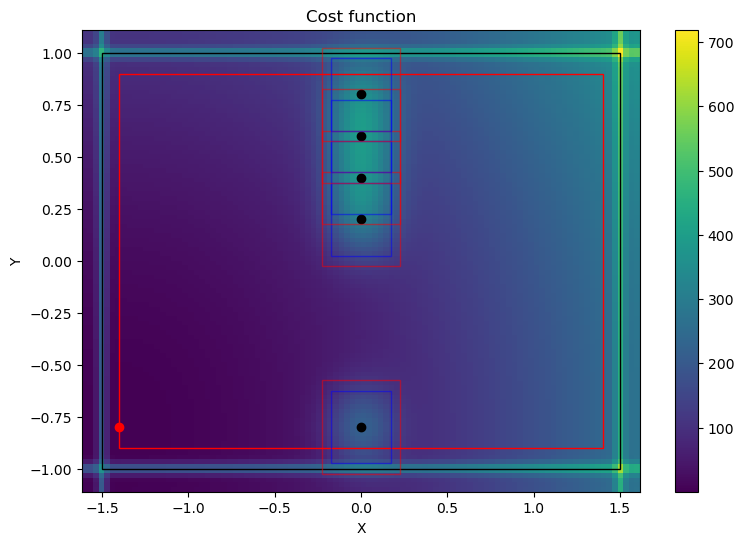

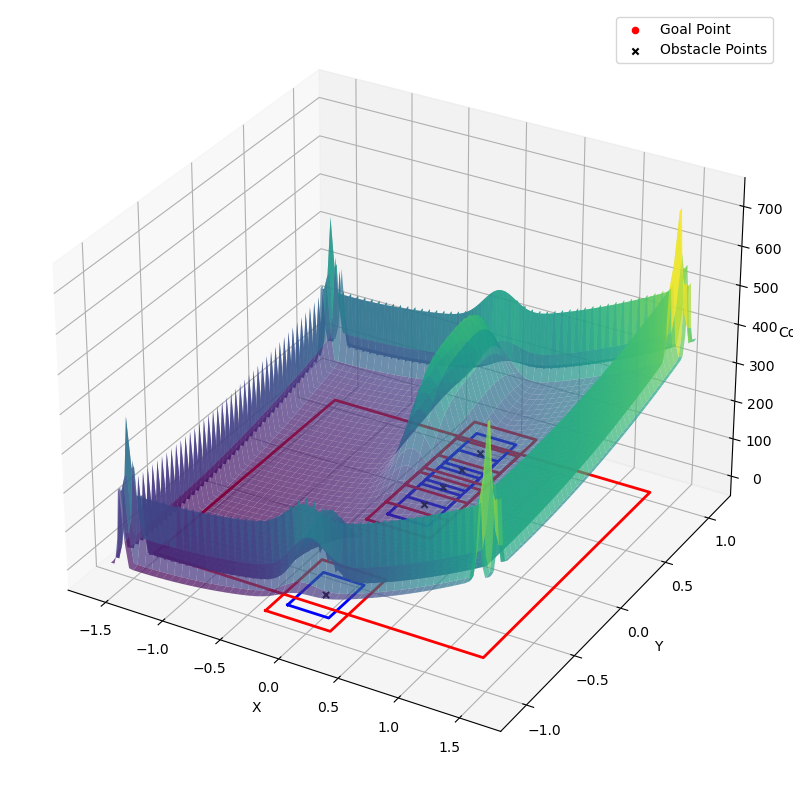

In [9]:
# Define goal and obstacle points
goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
# goal_points = np.array(np.mat('0; 0; 0')) # test

obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points, obs_points)


Dal plot si può notare come alcuni ostacoli dati dalla traccia sono mappati fuori dal confine del robotarium, ma si assume che la scelta è stata fatta per modellare ostacoli di dimensione differente, magari inferiore su quel punto specifico

# WP2

In [86]:
#WP2: Simulate (4 experiments) and visualize each robot's trajectory

In questa cella viene effettuata la simulazione del robot, in particolare, per un singolo robot, vengono effettuati 4 esperimenti, in cui il robot parte da 4 posizioni diverse. 
Nello specifico, è stato fornito un set di condizioni iniziali di esempio, che sono state utilizzate per effettuare la simulazione.
Innanzitutto viene inizializzato l'enviroment robotarium e creato il mapping tra il sistema unicycle del robot e il sistema single integrator. Tralasciamo la descrizione del modello unicycle, ampiamente descritta
nella documentazione del robotarium, e ci concentriamo sul modello single integrator, che è quello che interessa per la simulazione, non è necessario conoscerlo per la risoluzione del problema di controllo. Successivamente
viene effettuato un esperimento alla volta, il quale prevede:
- il recupero della posa del robot (che nel caso del robotarium recupera la posizione della hand position del robot) a cui viene iniettato del rumore per simulare gli eventuali errori di misura del sensore di posizione del robot;
- viene effettuato il passo di controllo attraverso la funzione $\bold{Control\_step}$ che restituirà l'azione ottima come descritto in precedenza;
- viene effettuata la conversione dell'azione ottima in velocità del robot, attraverso la funzione $\bold{si\_to\_uni\_dyn}$;
- vengono assegnate le velocità al robot;
- viene effettuato il passo di simulazione.

Per quanto riguarda le simulazioni, sono state lasciate le condizioni iniziali della traccia, nonostante nel report finale sono state infoltite e modificate per provare condizioni iniziali diverse e per avere maggiori simulazioni per la ricostruzione del costo del problema $\bold{IOC}$

Come anche per alcune funzioni successive, si è deciso di rendere generalizzato il seguente script, per permettere di testare il codice su diversi scenari, e di conseguenza, renderlo una funzione:

In [29]:

def genericSimulation(initial_conditions,goal_points,obs_points):
    # Instantiate Robotarium object
    N = 1 #Amount of robots per simulation

    N_experiment = len(initial_conditions)
    # X_si is going to be two-dimensional state history
    X_Si = [0]*N_experiment
    # D_Xi is going to be two-dimensional inputs history
    D_Xi = [0]*N_experiment

    # This first for loop creates the initial conditions
    for I in range(N_experiment):

        X_si = []
        D_xi = []

        r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

        # Create mapping from the control inputs to the actual velocity commands to the unicycle
        # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
        si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
        _, uni_to_si_states = create_si_to_uni_mapping()
        
        # define x initially
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        # Plotting Parameters
        CM = np.random.rand(N+10,3) # Random Colors
        goal_marker_size_m = 0.15
        obs_marker_size_m = 0.15
        marker_size_goal = determine_marker_size(r,goal_marker_size_m)
        marker_size_obs = determine_marker_size(r,obs_marker_size_m)
        font_size = determine_font_size(r,0.1)
        line_width = 5

        # Create Goal Point Markers
        #Text with goal identification
        goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
        #Plot text for caption
        goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(goal_points.shape[1])]
        goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
        for ii in range(goal_points.shape[1])]

        #Text with goal identification
        obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
        #Plot text for caption
        obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(obs_points.shape[1])]
        obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
        for ii in range(obs_points.shape[1])]

        r.step()

        # While the robot is away from the objective ...
        while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

            try:
                # Get poses of agents
                x = r.get_poses()
                x_si = uni_to_si_states(x)

                #Add to the dataset
                X_si.append(x_si)

                # The lines below define the pdf of the robot 
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
                x_sample = x_pdf.rvs() #Noisy state

                # This is about plotting
                for j in range(goal_points.shape[1]):
                    goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

                for j in range(obs_points.shape[1]):
                    obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

                # Task: compute the action from the policy. Call the variable dxi: 
                # this is the action sampled from the optimal solution to the control problem
                dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points) 
                '''
                Questa funzione è stata definita nel WP1, e rappresenta la policy ottima, che viene campionata per ottenere l'azione da eseguire.
                '''
                D_xi.append(dxi)

                # Transform single integrator velocity commands to unicycle inputs (low level controller)
                dxu = si_to_uni_dyn(dxi, x)

                # Set the velocities inputs
                r.set_velocities(np.arange(N), dxu)
                # Iterate the simulation
                r.step()
            except:
                break

        D_Xi[I] = D_xi
        X_Si[I] = X_si

        #Call at end of script to print debug information and for your script to run on the Robotarium server properly
        r.call_at_scripts_end()

        '''
        Dato che grazie a matplotlib qt è possibile visualizzare la simulazione live, è stato aggiunto un ramo try except per bloccare forzatamente l'esperimento, in caso di non raggiungimento del goal point in tempi ragionevoli.
        Inoltre si fa notare che, per gli esperimenti effettuati sul robotarium reale, il try except è stato sostituito con un timeout, in modo da non bloccare l'esperimento a mano, ma semplicemente farlo terminare dopo un tempo
        ragionevole, facendo in modo che in caso di blocco del robot, l'esperimento finisca comunque.
        '''
    return X_Si,D_Xi


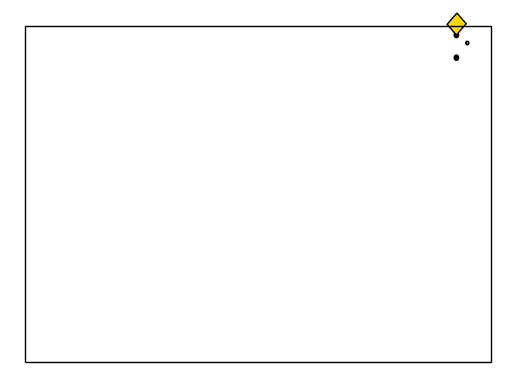

##### DEBUG OUTPUT #####
Your simulation will take approximately 60 real seconds when deployed on the Robotarium. 

	 Simulation had 5018 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

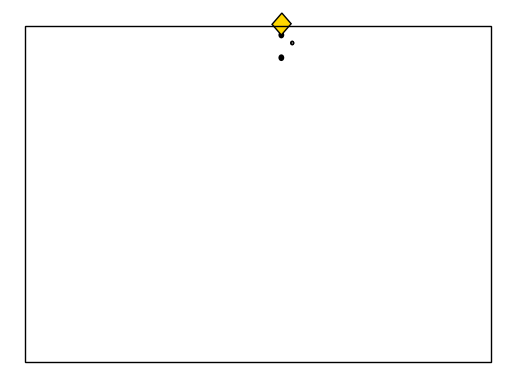

##### DEBUG OUTPUT #####
Your simulation will take approximately 45 real seconds when deployed on the Robotarium. 

	 Simulation had 6210 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

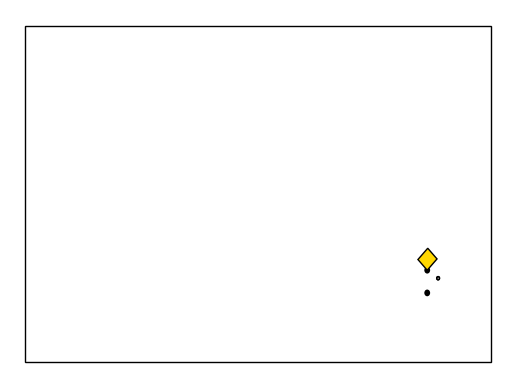

##### DEBUG OUTPUT #####
Your simulation will take approximately 43 real seconds when deployed on the Robotarium. 

	 Simulation had 7347 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

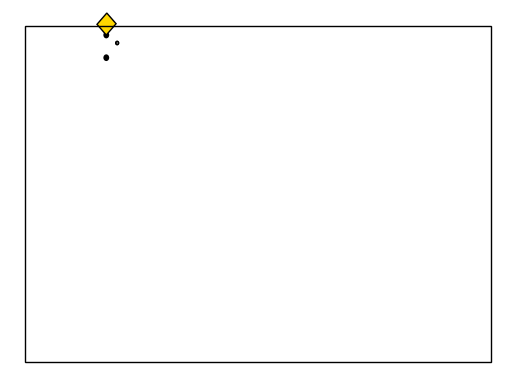

##### DEBUG OUTPUT #####
Your simulation will take approximately 31 real seconds when deployed on the Robotarium. 

	 Simulation had 8125 iteration(s) where the actuator limits were exceeded.


<Figure size 640x480 with 0 Axes>

In [32]:
initial_conditions = [np.array(np.mat('1.4; 0.9; 0')),np.array(np.mat('0.2; 0.9; 0')),np.array(np.mat('1.2; -0.5; 0')),np.array(np.mat('-1; 0.9; 0'))] #Initial pose of the robots

X_Si,D_Xi = genericSimulation(initial_conditions,goal_points,obs_points)

In [33]:
XX = X_Si
UU = D_Xi



Nelle prossime celle è stato effettuato un leggero refactoring del codice, per rendere il tutto delle funzioni. Questo perchè, in work package successivi, l'uso intensivo di queste funzionalità si è reso tale da portarci inevitabilmente a definire delle funzioni

In [34]:
def prepareDataForPlotting(XX, UU):
    #Prepare data for plotting
    X = []
    X_plot = []
    U = []
    U_plot = []

    for i in range(len(XX)):
        X.append(np.array(XX[i]))
        X_plot.append(np.array(XX[i]))

    X = np.concatenate(X, axis=0)
    X = np.reshape(X, (-1, 2))

    U = []
    for i in range(len(UU)):
        U.append(np.array(UU[i]))
        U_plot.append(np.array(UU[i]))

    U = np.concatenate(U, axis=0)
    U = np.reshape(U, (-1, 2))
    return X, X_plot, U, U_plot

In [35]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

def plotTrajectory(X_plot,obs_points,goal_points): 
 
    plt.figure(figsize=(9, 6)) 
 
    for i in range(len(X_plot)): 
        plt.plot(X_plot[i][:, 0], X_plot[i][:, 1], label=f'Traiettoria {i+1}') 
        plt.plot(X_plot[i][0, 0],X_plot[i][0, 1],'*',color='black',markersize=10) 

    for i in range(np.size(obs_points,axis=1)): 
        obstacle_square= plt.Rectangle((obs_points[0,i]-0.175,obs_points[1,i]-0.175), 0.35, 0.35, fc='red',ec="black")
        obstacle_hand_position = patches.Rectangle((obs_points[0,i]-0.225, obs_points[1,i]-0.225), 0.45, 0.45, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)

        plt.gca().add_patch(obstacle_square)
        plt.gca().add_patch(obstacle_hand_position) 
     
 
    square= plt.Rectangle((goal_points[0,0]-0.175,goal_points[1,0]-0.175), 0.35, 0.35, fc='green',ec="black") 
    plt.gca().add_patch(square) 
    plt.ylim(-1.1,1.1) 
    plt.xlim(-1.6,1.6) 
    plt.xlabel('X [m]') 
    plt.ylabel('Y [m]')
    plt.title('Robot trajectories')
    
    robotarium_border = patches.Rectangle((-1.5, -1), 1.5-(-1.5), 1-(-1), linewidth=1, edgecolor='black', facecolor='none') 
    hand_position_robotarium = patches.Rectangle((-1.4, -0.9), 1.4-(-1.4), 0.9-(-0.9), linewidth=1, edgecolor='red', facecolor='none')
  
    plt.gca().add_patch(robotarium_border)
    plt.gca().add_patch(hand_position_robotarium)
    
    
  

E' stata inoltre realizzato anche un plotting sulla mappa 3D del robot. Sappiamo che il robot non si muove in uno spazio tridimensionale, ma bidimensionale, ma avendo la funzione di costo è interessante capire come il robot segue la superficie della stessa. Purtroppo per problematiche del codice, a cui non siamo riusciti a porre rimedio, non è possibile vedere le traiettorie sulla superficie, e quindi è stato posto 0 sulla coordinata z. Il codice che prevede l'inizializzazione della coordinata z al valore del costo in quel punto serviva a questo scopo, ma purtroppo non siamo riusciti a risolvere questo problema di visualizzazione.

In [40]:
# TODO CAMBIARE I NOMI DENTRO
def plotTrajectory3D(X_plot,obs_points,goal_points): 
    x_min = -1.6  
    x_max = 1.6 
    y_min = -1.1 
    y_max = 1.1 
    x_range = np.linspace(x_min, x_max, 100)  
    y_range = np.linspace(y_min, y_max, 100)  
    X, Y = np.meshgrid(x_range, y_range)  
    Z = np.zeros((100, 100))  
    for i in range(100):  
        for j in range(100):  
            Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)  
    fig = plt.figure(figsize=(12,8))  
    ax = fig.add_subplot(111, projection='3d', autoscale_on=True)  
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)  # Update alpha value here  
    ax.set_xlabel('X')  
    ax.set_ylabel('Y')  
    ax.set_zlabel('Cost')  
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point')  
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here  
    
    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1], 0,  label=f'Trajectory {i+1}') 

    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.15, obs_points[0, i] - 0.15, obs_points[0, i] + 0.15, obs_points[0, i] + 0.15, obs_points[0, i] - 0.15]
        square_y = [obs_points[1, i] - 0.15, obs_points[1, i] + 0.15, obs_points[1, i] + 0.15, obs_points[1, i] - 0.15, obs_points[1, i] - 0.15]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
        # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.25, obs_points[0, i] - 0.25, obs_points[0, i] + 0.25, obs_points[0, i] + 0.25, obs_points[0, i] - 0.25]
        square_y_large = [obs_points[1, i] - 0.25, obs_points[1, i] + 0.25, obs_points[1, i] + 0.25, obs_points[1, i] - 0.25, obs_points[1, i] - 0.25]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)

    ax.legend() 
    plt.show()


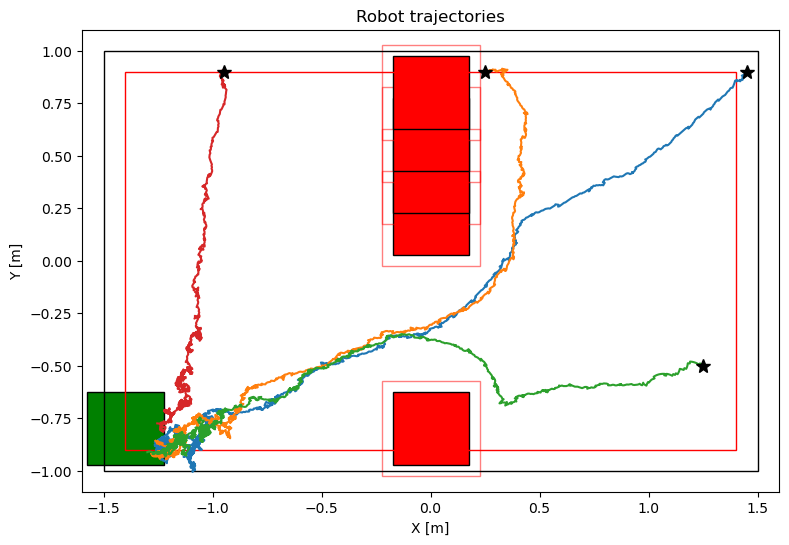

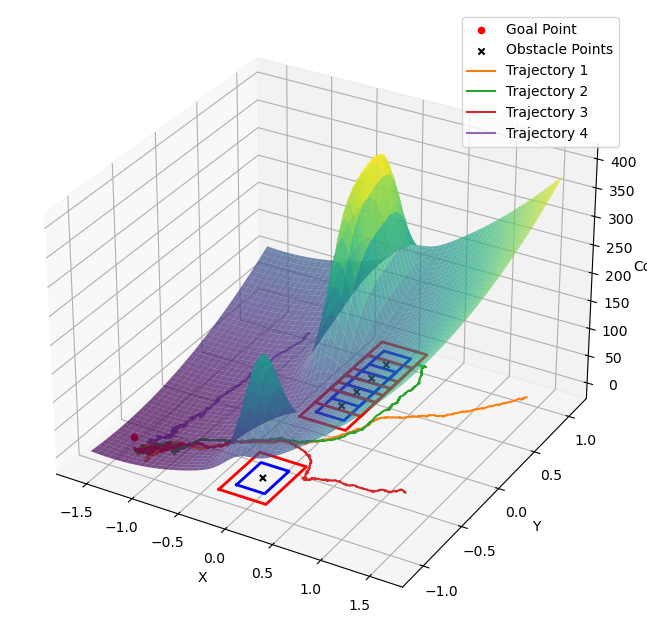

In [41]:
X, X_plot, U, U_plot = prepareDataForPlotting(XX, UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Come si può notare dal plot, le simulazioni raggiungono l'obiettivo, nonostante ci sia un pò di rumorosità nel raggiungere l'obiettivo, soprattutto in prossimità del medesimo

# WP3

In [37]:
##### WP3: Reverse engineer the features and visualize them #####

Le celle celle nel seguito, effettuano una parametrizzazione dell'ambiente robotarium come una griglia di punti. $\\$ Le feature proposte dal docente sono 16, la prima rappresenta la distanza rispetto al goal point, mentre le altre 15 rappresentano la distanza rispetto a dei punti fissi, che sono posizionati in maniera tale da cercare di
ricoprire l'intero spazio di task. $\\$
Questo set di feature, mappa in maniera fedele il costo dello stato relativo alla distanza dal goal point e dagli ostacoli, infatti ogni punto di feature è posizionato in un punto
dell'ambiente e, in base al relativo peso, esso rappresentarà la distanza da eventuali ostacoli presenti in quell'area dell'ambiente. $\\$
Data la natura del set di feature proposto, una prima analisi critica mette alla luce qualche problema: il numero di punti della griglia robotarium di riferimento sono in numero limitato.  $\\$
Questa "discretizzazione" della griglia potrebbe portare a una perdita di informazione, in quanto non è detto che è possibile ricavare tutte le informazioni riguardanti il costo dello stato a causa del numero ridotto di simulazioni,
e queste, anche se aumentassero in numero, potrebbero non coprire tutte le casistiche possibili. 
$\\$Per tale motivo una prima analisi critica porterebbe all'aumento del numero di punti della griglia robotarium, in modo da avere più informazioni
riguardo il costo dello stato, e quindi avere una migliore approssimazione del costo dello stato. 
$\\$ Inoltre non è presente alcuna feature che mappi la presenza dei bordi del task, ciò preoccupa poichè il robot potrebbe decidere di uscire dai bordi sfruttando il costo stimato derivante da queste feature

In [38]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))


In [39]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))

    return features



# WP4

In [ ]:
##### WP4: using the previously defined features solve the inverse optimal control problem. 
#          Plot the estimated cost. 
#          Verify that the estimated cost allows the robot to complete the task #####

Prima di introdurre ulteriormente il codice, per supporto all'analisi dello stesso e delle scelte progettuali già fatte all'interno del codice fornito, e quelle compiute dal gruppo, si fa riferimento alla formalizzazione del problema di controllo inverso effettuato nella relazione in allegato al codice del progetto. In particolare, si riporta la formula semplificata la per la risoluzione dell'$\bold {IOC}$ nel caso in cui la $q_{0:N}$ è uniforme:
$$argmin_w\{\sum^M_{k=1}(\mathbb{E_{p(x_k|\hat x_{k-1},\hat u_k)}}[w_k^Th(x_k)]+ln(\sum_{u_k}exp(\mathbb{E_{p(x_k|\hat x_{k-1},u_k)}}[-ln(p(x_k|\hat x_{k-1},u_k))+w_k^Th(x_k)])))\} \space \space \bold{(4)}$$

Inoltre indichiamo, per semplicità di notazione
$$exp(\mathbb{E_{p(x_k|\hat x_{k-1},u_k)}}[-ln(p(x_k|\hat x_{k-1},u_k))]) = -p(x_k|\hat x_{k-1},u_k).entropy()\space \space\bold{(5)}$$
e inoltre:
$$\mathbb{E_{p(x_k|\hat x_{k-1},u_k)}}[w_k^Th(x_k)] \space \space \bold{(6)}$$
e infine:
$$\mathbb{E_{p(x_k|\hat x_{k-1},\hat u_k)}}[w_k^Th(x_k)] \space \space \bold{(7)}$$
così da poter meglio esplicitare le scelte progettuali del seguito.
Ricordiamo che anche in questo caso, per mapping con le variabili del codice, consideriamo $$f = p(x_k|\hat x_{k-1},u_k)$$ $$f\_sampled = p(x_k|\hat x_{k-1},\hat u_k)$$

In [22]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nel markdown, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    '''
    Come specificato nel termine (7) del markdown, il valore atteso delle feature, in questo caso, è effettuato sulla f_sampled, in cui stato passato e azione sono stati recuperati dai dati reali delle traiettorie.
    '''

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nel markdown, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4). Inoltre bisogna aggiungere il termine
    (7) calcolato precendemente.
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

c:\Users\giova\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\giova\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


status: optimal
optimal value -7764.115488553604


A termine dell'ottimizzazzione vengono visualizzati i pesi calcolati dal problema. $\\$ In questo caso particolare notiamo che i pesi relativi al mapping dello spazio assumono valori più alti, in segno negativo, più vicini sono
agli ostacoli.$\\$ Ovviamente questo ha senso, poichè il costo, è combinazione lineare di queste feature cambiate di segno e pesate per i relativi pesi, e riesce a rappresentare in maniera fedele il costo dello stato, 
poichè è più alto in vicinanza dei punti in cui sono concentrati più ostacoli. $\\$ Inoltre anche il peso della feature che mappa la distanza dal goal point è negativo e di modulo alto, 
e questo ha senso in quanto il costo dello stato è tanto più alto quanto più il robot è lontano dal goal point. $\\$ Purtroppo non è presente alcun termine che mappi la presenza dei bordi del robotarium.

In [23]:
# Show the values: critically discuss if these weights make sense
weights = w.value

print('weights:',weights)



weights: [[-11.31925151  -7.50862941   0.34349784  -1.03974843 -12.40860846
   -7.41769198  -0.73244681  -0.27797483   1.81851854  -0.3449568
    0.25215822  -0.15838058  -0.17476424  -0.02854172   0.14564335
    0.38722877]]


Come descritto anche in precedenza, l'ottimizzazione è andata a buon fine e il valore dei pesi calcolati è ragionevole in relazione allo specifico task attuato.
Il fatto che lo status sia optimal indica che l'ottmizzazione ha raggiunto con successo la soluzione ottimale, trovando il miglior valore possibile rispetto alla funzione obiettivo.

In [24]:
# Check the status of the optimization problem: did the optimization go well?
print("status:", prob.status)
print("optimal value", prob.value)


status: optimal
optimal value -7764.115488553604


In [25]:
# Reformatting the original cost map (just for checking and plotting purposes)

import numpy as np
import scipy.stats as st
import pandas as pd

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

#obs_points = np.array(np.mat('0 0 0 0 0 0;0 0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.02, 0.02], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 20*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost(state,goal_points,obs_points)

Coat_Map = pd.DataFrame(Cost_Map,index=list(X_axis),columns=Y_axis)

In [26]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

Nella successiva cella visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.

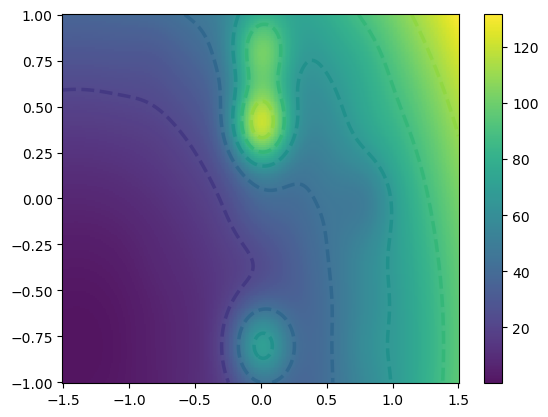

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()




La funzione ha la sintassi e il significato analogo a quella definita per il problema di $\bold{FOC}$, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema $\bold{IOC}$.

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)


                N_samples = 20
                next_sample = f.rvs(N_samples)

                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                '''
                L'unica differenza è nella funzione di costo che viene interpellata
                '''

                log_DKL = np.exp(-cost+f.entropy())

                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        S2 = np.sum(pf)

        pf = pf/S2

        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

Grazie al fatto che la simulazione è stata resa funzione, è possibile semplicemente chiamarla nel modo seguente:

initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]

X_Si,D_Xi = genericSimulation(initial_conditions,goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi

Infine, ancora una volta come nel FOC, plottiamo i risultati degli esperimenti. $$\\$$ Effettivamente, per le condizioni iniziali scelte da traccia, il robot riesce a raggiungere il goal point,
ma non è detto che questo accada sempre, infatti se si cambiano le condizioni iniziali, il robot potrebbe non raggiungere il goal point, inoltre, dato che non ci sono feature che mappino i muri, il robot a volte esce anche dai
bordi. $$\\$$
Proprio per tale motivo si è deciso di modellare una nuova funzione di costo e un nuovo set di feature, così come richiesto dal WP5.

In [ ]:
X, X_plot, U, U_plot = prepareDataForPlotting(XX, UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

Infine, prima di passare alla modellazione di una nuova funzione di costo e di un nuovo set di feature, viene visualizzato il set di feature utilizzato per il problema di IOC.
In particolare, i punti caratteristici sono rappresentati come dei cerchi rossi, e la dimensione del cerchio è proporzionale al peso associato alla feature, in particolare, più il peso è alto, più il cerchio sarà grande. 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
newWeights=-weights[0][1:]
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900) 


plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()


In [ ]:
# Comment the results you observe in the figure generated by the above cell


Come enunciato già in precedenza, alla visualizzazione non grafica, ma analitica dei pesi, notiamo che i pesi relativi al mapping dello spazio assumono valori più alti, in segno negativo, più vicini sono
agli ostacoli. Ovviamente questo ha senso, poichè il costo, combinazione lineare di queste feature, riesce a rappresentare in maniera fedele il costo dello stato, poichè è più alto in vicinanza dei punti in cui sono concentrati
più ostacoli. 

# WP5

In [ ]:
'''
Prima di proporre un nuovo costo e nuove feature, ci siamo interessati a comprendere a pieno l'environment robotarium e le sue caratteristiche, in particolare, ci siamo interessati a capire la dimensione
dell'ostacolo che viene effettivamente inserito come parametro del robotarium. Dopo aver fatto vari test, abbiamo notato che l'ostacolo viene rappresentato come un rettangolo di dimensioni 0.35x0.35m, e questo
vale anche per la zona di goal point, siamo riusciti a comprenderlo grazie a varie simulazioni di test inviate alla piattaforma online del robotarium, ciò che ci ha fatto capire quale fosse la dimensione dell'ostacolo
è la seguente simulazione, effettuata con ostacoli distanti 0.35 fra di loro:
https://robotzoo-video.ecs.gatech.edu/owncloud/index.php/s/bUUjobOimI5ftYC
'''

obs_points = np.array(np.mat('0 ;0 ;0 ')) # da traccia
goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost(state,goal_points,obs_points):
    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
   


    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) # Questo dipende dalle gaussiane mediate negli ostacoli,
    
    return(gauss_sum)

'''
Avendo compreso la dimensione dell'ostacolo, abbiamo deciso di modellare nuovamente il termine gaussiano, in modo da avere una rappresentazione più fedele della realtà, in particolare, abbiamo deciso di rappresentarlo
con una varianza minore, manetenendo più o meno lo stesso valore di costo nel picco. Si fa notare come questo valore della varianza non crei semplicemente una gaussiana che assume valori all'interno dell'ostacolo, ma ha anche valori
in un intorno dell'ostacolo. Questo è dovuto all'"hand-position problem", o almeno questo è il nome che gli abbiamo attribuito. In particolare questo problema, deriva dalla rappresentazione del robot, la cui posa recuperata dall'environment
è quella della sua hand position, che si trova a 0.05m dal centro del robot, che a sua volta è lungo all'incirca 0.10/0.11m. Dato ciò, e dato che il robot può comunque muoversi in retromarcia, potrebbe capitare che se la gaussiana
non è molto ampia, il robot prima di accorgersi che il costo si sta alzando, comunque sbatte con il retro del suo corpo verso l'ostacolo. Grazie all'aiuto del plot, è possibile vedere come abbiamo modellato l'effettivo ostacolo
come un rettangolo blu, mentre la posizione "safe" di hand-position in rosso. In questo modo il robot non tenderà di avvicinarsi neanche a questa safe position, e se lo farà in retromarcia comunque arriverà al massimo vicino all'ostacolo
senza mai toccarlo effettivamente. Ragionamenti analoghi possono essere portati avanti per i limiti fisici del robotarium, noi vogliamo che anche se il robot arriva in retromarcia lungo i bordi non tocchi mai effettivamente i bordi
per tale motivo, nell'avanzare del miglioramento del costo, si è tenuto conto anche di questo fattore.
'''

In [ ]:
plot_heatmap(goal_points,obs_points)
'''
Come preannunciato nella definizione della funzione, abbiamo spiegato come mai dell'inserimento di un rettangolo blu, che rappresenta l'ostacolo, e un rettangolo rosso, che rappresenta la posizione "safe" di hand-position.
'''

In [ ]:
plot_3d_heatmap(goal_points,obs_points)
'''
Lo stesso vale in questo caso
'''

## Aggiunto gaussiana inversa centrata sul goal point

In [ ]:
%matplotlib qt

'''
Grazie al seguente widget di matplotlib, possiamo visualizzare in maniera interattiva i grafici in altre finestre, ma soprattutto è possibile vedere in live la simulazione del robot sul simulatore robotarium
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "Training_Trajectories.jpg"

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')  
plt.show()


In [ ]:
'''
Come prima modifica alla funzione di costo si fa notare un comportamento non ottimo che il robot ha quando si trova in prossimità del goal point, infatti, come si può notare dall'immagine qui sopra, il robot, nonostante arrivi in prossimità
del goal point, non riesce a fermarsi subito, ma continua a muoversi in un intorno del goal point. Questo comportamento è dovuto al fatto che il costo dello stato è calcolato come la distanza dal goal point, e quindi, quando il robot si trova in prossimità
il costo nel suo intorno assume valori simili, portando il robot a non puntare subito direttamente al goal point. Per tale motivo si è deciso di modificare la funzione di costo, in modo da rendere il costo in prossimità del goal point più "scalato", in maniera
gauassiana, e quindi, in prossimità del goal point, il costo diminuisce rapidamente, portando il robot a puntare subito al goal point, senza girarci intorno.
'''

In [ ]:
def state_cost(state,goal_points,obs_points):
    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar)
    
    sigma=0.02
    cost = -10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                  +np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
   
    return(cost)

'''
Di conseguenza aggiungiamo un termine inverso per la gaussiana del goal point, con varianza uguale a quella dell'ostacolo, ma con valore leggermente minore, questo per evitare che in caso di errori di pianificazione, e scelta del goal point in prossimità,
se non sull'ostacolo, il robot non provi ad andare nell'ostacolo per provare a raggiungere il goal point, ma ne rimanga comunque respinto.
'''

In [ ]:

goal_points = np.array(np.mat('-1.4; -0.8; 0')) 

obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))

'''
Definiamo un esperimento analogo a quello della traccia, per far notare le differenze nella scelta di questo costo
'''

In [ ]:
plot_heatmap(goal_points,obs_points)

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
'''
Per le simulazioni future, abbiamo semplicemente deciso di rendere la simulazione una funzione, così da poterla semplicemente richiamare senza riscrivere nuovamente il codice
'''

def genericSimulation(initial_conditions,goal_points,obs_points):
    # Instantiate Robotarium object
    N = 1 #Amount of robots per simulation

    N_experiment = len(initial_conditions)
    # X_si is going to be two-dimensional state history
    X_Si = [0]*N_experiment
    # D_Xi is going to be two-dimensional inputs history
    D_Xi = [0]*N_experiment

    # This first for loop creates the initial conditions
    for I in range(N_experiment):

        X_si = []
        D_xi = []

        r = robotarium.Robotarium(number_of_robots=N, show_figure=True, initial_conditions=initial_conditions[I], sim_in_real_time=False)

        # Create mapping from the control inputs to the actual velocity commands to the unicycle
        # Note: this is a very practical situation (robots often provide transformation functions to low level commands)
        si_to_uni_dyn = create_si_to_uni_dynamics_with_backwards_motion() #Converts single integrator inputs to unicycle inputs (low-level controller)
        _, uni_to_si_states = create_si_to_uni_mapping()
        
        # define x initially
        x = r.get_poses()
        x_si = uni_to_si_states(x)

        # Plotting Parameters
        CM = np.random.rand(N+10,3) # Random Colors
        goal_marker_size_m = 0.15
        obs_marker_size_m = 0.15
        marker_size_goal = determine_marker_size(r,goal_marker_size_m)
        marker_size_obs = determine_marker_size(r,obs_marker_size_m)
        font_size = determine_font_size(r,0.1)
        line_width = 5

        # Create Goal Point Markers
        #Text with goal identification
        goal_caption = ['G{0}'.format(ii) for ii in range(goal_points.shape[1])]
        #Plot text for caption
        goal_points_text = [r.axes.text(goal_points[0,ii], goal_points[1,ii], goal_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(goal_points.shape[1])]
        goal_markers = [r.axes.scatter(goal_points[0,ii], goal_points[1,ii], s=marker_size_goal, marker='s', facecolors='none',edgecolors=CM[ii,:],linewidth=line_width,zorder=-2)
        for ii in range(goal_points.shape[1])]

        #Text with goal identification
        obs_caption = ['OBS{0}'.format(ii) for ii in range(obs_points.shape[1])]
        #Plot text for caption
        obs_points_text = [r.axes.text(obs_points[0,ii], obs_points[1,ii], obs_caption[ii], fontsize=font_size, color='k',fontweight='bold',horizontalalignment='center',verticalalignment='center',zorder=-2)
        for ii in range(obs_points.shape[1])]
        obs_markers = [r.axes.scatter(obs_points[0,ii], obs_points[1,ii], s=marker_size_obs, marker='s', facecolors='none',edgecolors=CM[ii+1,:],linewidth=line_width,zorder=-2)
        for ii in range(obs_points.shape[1])]

        r.step()

        # While the robot is away from the objective ...
        while (np.size(at_pose(np.vstack((x_si,x[2,:])), goal_points, position_error=0.15,rotation_error=100)) != N):

            try:
                # Get poses of agents
                x = r.get_poses()
                x_si = uni_to_si_states(x)

                #Add to the dataset
                X_si.append(x_si)

                # The lines below define the pdf of the robot 
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                x_pdf = st.multivariate_normal(x_si.reshape((2,)),cov)
                x_sample = x_pdf.rvs() #Noisy state

                # This is about plotting
                for j in range(goal_points.shape[1]):
                    goal_markers[j].set_sizes([determine_marker_size(r, goal_marker_size_m)])

                for j in range(obs_points.shape[1]):
                    obs_markers[j].set_sizes([determine_marker_size(r, obs_marker_size_m)])

                # Task: compute the action from the policy. Call the variable dxi: 
                # this is the action sampled from the optimal solution to the control problem
                dxi = Control_step(x_sample,U_space_1,U_space_2,goal_points,obs_points) 

                D_xi.append(dxi)

                # Transform single integrator velocity commands to unicycle inputs (low level controller)
                dxu = si_to_uni_dyn(dxi, x)

                # Set the velocities inputs
                r.set_velocities(np.arange(N), dxu)
                # Iterate the simulation
                r.step()
            except:
                break

        D_Xi[I] = D_xi
        X_Si[I] = X_si

        #Call at end of script to print debug information and for your script to run on the Robotarium server properly
        r.call_at_scripts_end()

        '''
        Dato che grazie a matplotlib qt è possibile visualizzare la simulazione live, è stato aggiunto un ramo try except per bloccare forzatamente l'esperimento, in caso di non raggiungimento del goal point
        '''
    return X_Si,D_Xi


In [ ]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots

X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
'''
E' stata creata una funzione anche per la preparazione dei dati per il plotting
'''

def prepareDataForPlotting(XX, UU):
    #Prepare data for plotting
    X = []
    X_plot = []
    U = []
    U_plot = []

    for i in range(len(XX)):
        X.append(np.array(XX[i]))
        X_plot.append(np.array(XX[i]))

    X = np.concatenate(X, axis=0)
    X = np.reshape(X, (-1, 2))

    U = []
    for i in range(len(UU)):
        U.append(np.array(UU[i]))
        U_plot.append(np.array(UU[i]))

    U = np.concatenate(U, axis=0)
    U = np.reshape(U, (-1, 2))
    return X, X_plot, U, U_plot

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib import cm 
from matplotlib.ticker import LinearLocator 
import numpy as np 

'''
E anche una funzione per il plot delle traiettorie in 2D
'''
def plotTrajectory(X_plot,obs_points,goal_points): 
 
#Task: plot trajectories with different colors 
    plt.figure(figsize=(9, 6)) 
 
    for i in range(len(X_plot)): 
        plt.plot(X_plot[i][:, 0], X_plot[i][:, 1], label=f'Traiettoria {i+1}') 
        plt.plot(X_plot[i][0, 0],X_plot[i][0, 1],'*',color='black',markersize=10) 
 
    ''' 
    Le linee di codice precedenti servono per visualizzare le traiettorie dei robot, in particolare, per ogni esperimento viene visualizzata la traiettoria del robot, mappandola con un diverso colore aggiungendo 
    un marker alla posizione iniziale del robot. 
 
    NOTA: nelle successive linee di codice, vengono plottati i goal point e gli ostacoli, ma non rappresentano in maniera fedele la realtà, in quanto sono stati plottati in un ambiente 2D e rappresentati come rettangoli, mentre, 
    come già discusso in precedenza, gli ostacoli dovrebbero essere rappresentati più come delle sfere, a causa della natura gaussiana multivariata che rappresenta la distanza. 
    ''' 
    square= plt.Rectangle((goal_points[0,0]-0.175,goal_points[1,0]-0.175), 0.35, 0.35, fc='green',ec="black") 

    #Draw obstacles 
    for i in range(np.size(obs_points,axis=1)): 
        # square= plt.Rectangle((obs_points_f[0,i]-0.1,obs_points_f[1,i]-0.1), 0.2, 0.2, fc='red',ec="black")
        square= plt.Rectangle((obs_points[0,i]-0.175,obs_points[1,i]-0.175), 0.35, 0.35, fc='red',ec="black")
        obstacle_square2 = patches.Rectangle((obs_points[0,i]-0.225, obs_points[1,i]-0.225), 0.45, 0.45, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)

        plt.gca().add_patch(obstacle_square2)
        plt.gca().add_patch(square) 
     
 
    square= plt.Rectangle((goal_points[0,0]-0.175,goal_points[1,0]-0.175), 0.35, 0.35, fc='green',ec="black") 
    plt.gca().add_patch(square) 
    plt.ylim(-1.1,1.1) 
    plt.xlim(-1.6,1.6) 
    plt.xlabel('X [m]') 
    plt.ylabel('Y [m]')
    plt.title('Robot trajectories')
    
    arena_border = patches.Rectangle((-1.5, -1), 1.5-(-1.5), 1-(-1), linewidth=1, edgecolor='black', facecolor='none')
    plt.gca().add_patch(arena_border)


In [ ]:
XX = X_Si
UU = D_Xi

_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
'''
E anche una funzione per il plot delle traiettorie in 3D, sappiamo che il robot non si muove in uno spazio tridimensionale, ma in base alle traiettorie è possibile capire quali sono state le scelte del robot e perchè
'''
 
def plotTrajectory3D(X_plot,obs_points,goal_points): 
    x_min = -1.6  
    x_max = 1.6 
    y_min = -1.1 
    y_max = 1.1 
    x_range = np.linspace(x_min, x_max, 100)  
    y_range = np.linspace(y_min, y_max, 100)  
    X, Y = np.meshgrid(x_range, y_range)  
    Z = np.zeros((100, 100))  
    for i in range(100):  
        for j in range(100):  
            Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points)  
    fig = plt.figure(figsize=(12,8))  
    ax = fig.add_subplot(111, projection='3d', autoscale_on=True)  
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)  # Update alpha value here  
    ax.set_xlabel('X')  
    ax.set_ylabel('Y')  
    ax.set_zlabel('Cost')  
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point')  
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here  
    
    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1], 0,  label=f'Trajectory {i+1}') 

    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.15, obs_points[0, i] - 0.15, obs_points[0, i] + 0.15, obs_points[0, i] + 0.15, obs_points[0, i] - 0.15]
        square_y = [obs_points[1, i] - 0.15, obs_points[1, i] + 0.15, obs_points[1, i] + 0.15, obs_points[1, i] - 0.15, obs_points[1, i] - 0.15]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
        # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.25, obs_points[0, i] - 0.25, obs_points[0, i] + 0.25, obs_points[0, i] + 0.25, obs_points[0, i] - 0.25]
        square_y_large = [obs_points[1, i] - 0.25, obs_points[1, i] + 0.25, obs_points[1, i] + 0.25, obs_points[1, i] - 0.25, obs_points[1, i] - 0.25]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)

    ax.legend() 
    plt.show()


In [ ]:
plotTrajectory3D(X_plot,obs_points,goal_points)


In [ ]:
'''
Dopo aver inserito questo nuovo termine facciamo notare come, in caso di sbagliata pianificazione, il robot non si avvicina mai all'ostacolo, ma rimane sempre a una distanza di sicurezza, e questo è dovuto al fatto che il costo della gaussiana inversa è minore
rispetto a quello della gaussiana sull'ostacolo
'''
goal_points = np.array(np.mat('0; 0; 0'))

obs_points = np.array(np.mat('0 ;0;0')) 


plot_heatmap(goal_points,obs_points)

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions=[np.array(np.mat('1.4;0.9; 0'))] 
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

'''
Come vediamo il robot non tenta di andare nel goal point, ma rimane respinto dall'ostacolo, da notare come viene in caso di sovrapposizione abbiamo deciso di mostrare l'ostacolo implicitamente assumendo che il goal point
fosse nello stesso punto
'''

# PROVA CON CLUSTERING

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "Wall.jpeg"

image = mpimg.imread(image_path)

plt.imshow(image)
plt.axis('off')  
plt.show()


In [ ]:
'''
Ulteriore appunto che possiamo fare al costo attuale, è che, come è possibile vedere dal plot 3D qui sopra, il cluster di ostacoli crea una sorta di "muro" che porta il robot a fermarsi intorno al suo punto medio, in caso di goal point posizionato dietro
al cluster di ostacoli. Per evitare ciò, c'è bisogno che anche il cluster sia modellato come una gaussiana per permettere così al robot di "scivolare" ai bordi del cluster e raggiungere il goal point. Questo lo abbiamo raggiunto grazie alla modellazione
degli ostacoli tramite grafo, così da trovare i cluster, e modellazione del costo del clustering come una gaussiana centrata nel centro geometrico del cluster.
La scelta di clusterizzazione per una distanza < 0.45 tra gli ostacoli, è per discretizzare quei gruppi di ostacoli tra i quali il robot non passerebbe (il robot è grosso 0.11 cm, quindi se la distanza fra i centri degli ostacoli è < 0.45, allora sicuramente lì il robot
non passa)
'''

In [ ]:
import networkx as nx
from networkx.algorithms.community import girvan_newman
import matplotlib.pyplot as plt

'''
Funzione per creare il grafo, trovare le componenti connesse e calcolare il loro centro geometrico
'''
def clustering(obs_points):

    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(obs_points.shape[1]):
        G.add_node(i)

    # Add edges between nodes based on Euclidean distance
    for i in range(obs_points.shape[1]):
        for j in range(i+1, obs_points.shape[1]):
            distance = np.linalg.norm(obs_points[:,i] - obs_points[:,j])
            if distance <= 0.45:
                G.add_edge(i, j)

   
    # Find connected components
    connected_components = list(nx.connected_components(G))
    centroidi = []
    # Print connected components
    for i, component in enumerate(connected_components):
        sumx=0
        sumy=0
        for j in component:
            sumx+=obs_points[0][j]
            sumy+=obs_points[1][j]
        centroidi.append([sumx/len(component),sumy/len(component),len(component)])
    
    return centroidi


In [ ]:
'''
Funzione di costo con aggiunta del costo del clustering, in particolare verifichiamo che il centroide non sia troppo vicino al goal point, in caso contrario il costo tende a 0, altrimenti il costo è proporzionale ad una gaussiana centrata nel centroide e con valore
maggiore a seconda del numero di ostacoli che compongono il cluster, perchè maggiori gli ostacoli più velocemente vogliamo che il robot si spinga ai lati del cluster. In questo caso il goal point è assunto essere soltanto uno, in caso di più goal point, la funzione
deve essere modificata per tenerlo in conto
'''
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    cost2 = 0
    for i in range(len(centroidi)):
            dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) 
            dist=dist if dist < 0.175 else 1 
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist
            

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
  
    
    sigma=0.02
    cost = -10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 10*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cost2

    return(cost)

In [ ]:
goal_points = np.array(np.mat('-0.5; 0; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;-0.4 -0.2 0 0.2 0.4;0 0 0 0 0'))
'''
Verifichiamo con un esempio a doc cosa succede
'''

In [ ]:
plot_heatmap(goal_points,obs_points)

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.3; 0; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)
'''
Il robot, nonostante ai lati del cluster non riesca subito ad individuare la direzione ottimale per raggiungere il goal point, riesce comunque,anche grazie alla rumorosità inserità, a raggiungere il goal point
'''

In [ ]:
'''
Facciamo ora l'esperimento con le condizioni date da traccia
'''

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))


In [ ]:
plot_heatmap(goal_points,obs_points)

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)
'''
Anche in questo caso si comporta in maniera corretta e il robot riesce a raggiungere sempre l'obiettivo
'''

In [ ]:
'''
Facciamo notare come l'aggiunta del termine clustering non crea situazioni critiche, come potrebbe creare la gaussiana inversa (ma che abbiamo fatto notare come ciò non accade), poichè in caso di vicinanza al goal point, il valore
della gaussiana del clustering si riduce drasticamente
'''



# Aggiunta dell'hand position anche per muro 


In [ ]:
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    cost2 = 0
    for i in range(len(centroidi)):
            dist= (goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2 # da cambiare se sono più goal point #TODO
            dist=dist if dist < 0.175 else 1 #(%1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare)
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist
            # Se il centroide è trppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point


    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
  
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cost2
   

    return(cost)

'''
Come annunciato all'inizio della discussione, anche per quanto riguarda i bordi del robotarium abbiamo aggiunto una safe position per il problema dell'hand position del robot, aumentando un poco la varianza per "allungarsi" fino ai bordi teorici del muro
'''


In [ ]:
import matplotlib.patches as patches

'''
   Abbiamo ridefinito le funzioni per il plotting, per aggiungere anche il "nuovo bordo" da evitare, sia per il caso 2D che per il caso 3D
'''

def plot_heatmap(goal_points,obs_points):
    plt.figure(figsize=(9,6))
    x_min = -1.6
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min,x_max,100)
    y_range = np.linspace(y_min,y_max,100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            Z[i,j] = state_cost(np.array([X[i,j],Y[i,j]]),goal_points,obs_points)
    plt.pcolormesh(X,Y,Z)
    plt.colorbar()
    plt.scatter(goal_points[0],goal_points[1],c='r')
    plt.scatter(obs_points[0,:],obs_points[1,:],c='k')
    plt.title('Cost function')

    # Add labels to the axes
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    
    # Add a rectangle for the border of the arena
    arena_border = patches.Rectangle((-1.5, -1), 1.5-(-1.5), 1-(-1), linewidth=1, edgecolor='black', facecolor='none')
    arena_border2 = patches.Rectangle((-1.4, -0.9), 1.4-(-1.4), 0.9-(-0.9), linewidth=1, edgecolor='red', facecolor='none')

    plt.gca().add_patch(arena_border)
    plt.gca().add_patch(arena_border2)
    
    # Add squares for each obstacle
    for i in range(obs_points.shape[1]):
        obstacle_square = patches.Rectangle((obs_points[0,i]-0.175, obs_points[1,i]-0.175), 0.35, 0.35, linewidth=1, edgecolor='b', facecolor='none',alpha=0.5)
        obstacle_square2 = patches.Rectangle((obs_points[0,i]-0.225, obs_points[1,i]-0.225), 0.45, 0.45, linewidth=1, edgecolor='r', facecolor='none',alpha=0.5)

        plt.gca().add_patch(obstacle_square)
        plt.gca().add_patch(obstacle_square2)

    plt.show()

   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost(np.array([X[i, j], Y[i, j]]), goal_points, obs_points) 
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 
    
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    # Plot square centered at obstacle points
    square_x = [-1.4, -1.4, 1.4, 1.4, -1.4]
    square_y = [-0.9, 0.9, 0.9, -0.9, -0.9]
    ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
    
    # Add larger red square centered at obstacle points
    square_x_large = [-1.4, -1.4, 1.4, 1.4, -1.4]
    square_y_large = [-0.9, 0.9, 0.9, -0.9, -0.9]
    ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)

    ax.legend() 
    plt.show()



In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) 
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0'))
plot_heatmap(goal_points,obs_points)

'''
Effettuiamo l'esperimento dato da traccia
'''

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.4;0.9; 0')),np.array(np.mat('0.2;0.9; 0')),np.array(np.mat('1.2;-0.5; 0')),np.array(np.mat('-1;0.9; 0'))] #Initial pose of the robots
X_Si,D_Xi=genericSimulation(initial_conditions)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

''' 
Il robot si comporta bene
'''

In [ ]:
'''
Cerchiamo di capire se il robot potrebbe uscire dal robotarium e quindi inserire un termine "a muro" letteralmente per evitare che ciò accada
'''
goal_points = np.array(np.mat('1.25; 0.35; 0')) 
obs_points = np.array(np.mat('0.9 1.25;0.8 0.6 ;0 0'))
plot_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('1.25;0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points, obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)
'''Da alcuni test fatti, in questo caso bloccando manualmente la funzione, oppure #TODO condizione di terminazione, si nota come il robot non tenta di uscire dai limiti, ma piuttosto rimane intrappolato, il chè va bene, nel caso in cui
si trovino situazioni in cui il robot invece tenti di uscire, bisognerebbe agire nuovamente sulla funzione di costo per evitare ciò'''

## Esperimento interessante, robot in mezzo agli ostacoli

In [ ]:

goal_points = np.array(np.mat('0; 0; 0')) 
obs_points = np.array(np.mat('-0.4 -0.4 -0.4 0 0.4 0.4 0.4; -0.4 0 0.4 0.4 0.4 0 -0.4; 0 0 0 0 0 0 0'))

In [ ]:
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(goal_points,obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    cost2 = 0
    for i in range(len(centroidi)):
            dist= (goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2 # da cambiare se sono più goal point #TODO
            dist=dist if dist < 0.175 else 1 #(%1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare)
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist
            # Se il centroide è trppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point


    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
  
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cost2
   

    return(cost)


In [ ]:
plot_heatmap(goal_points,obs_points)

In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0;-0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)
'''
In questo caso il robot riesce a raggiungere l'obiettivo, nonostante un pò di difficoltà, avendo anche abbastanza spazio per passare tra gli ostacoli. Una simulazione simile, ma in cui il corridoio tra gli ostacoli fosse più piccolo, è stata fatta, e il robot
non riesce a raggiungere l'obiettivo, ma rimane intrappolato tra gli ostacoli.
'''

# Altri esperimenti 

In [ ]:

goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.25; 0 0 0' ))


In [ ]:
plot_heatmap(goal_points,obs_points)


In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0.9;0.85; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
_,X_plot,_,_=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

# Casi non risolti

In [ ]:

goal_points = np.array(np.mat('0.9; 0.85; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.25; 0 0 0' ))


In [ ]:
plot_heatmap(goal_points,obs_points)


In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0.0;0; 0'))]
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

# Altro caso non risolto

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) 
obs_points = np.array(np.mat('-0.35 -0.35 -0.35 0 0.35 0.35 0.35; -0.35 0 0.35 0.35 0.35 0 -0.35; 0 0 0 0 0 0 0'))


In [ ]:
plot_heatmap(goal_points,obs_points)


In [ ]:
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
initial_conditions = [np.array(np.mat('0;-0.8; 0')),np.array(np.mat('0;+0.8; 0'))] #Initial pose of the robots
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

# Cambio delle feature (Esperimento da traccia)

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
'''
Data la funzione di costo:
'''
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    cost2 = 0
    for i in range(len(centroidi)):
            dist= (goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2 # da cambiare se sono più goal point #TODO
            dist=dist if dist < 0.175 else 1 #(% 1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare)
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist
            # Se il centroide è trppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cost2
   

    return(cost)

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) # Da traccia

initial_conditions = [np.array(np.mat('1.45;0.95; 0')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.225;0.25; 3.14')),np.array(np.mat('1.45;0.25; 0')),np.array(np.mat('1.45;-0.75; 3.14')),np.array(np.mat('1;-0.95; 0')),
                      np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')),np.array(np.mat('-0.225;0.45; 0')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]


print(len(initial_conditions))
plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
# Se vuoi runnare di nuovo il FOC devi rieseguire il codice di definizione della control_step sopra.
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

### Aggiunta dei termini distanza dai muri

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia
#obs_points_f = np.array(np.mat('-1.35 -1.35 -1.35 -1.35 -1.35 -0.675 -0.675 -0.675 -0.675 -0.675 0 0 0 0 0 0.675 0.675 0.675 0.675 0.675 1.35 1.35 1.35 1.35 1.35;-0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
# obs_points_f = np.array(np.mat('0 0 0 0 0 0.5 0.5 0.5 0.5 0.5 -0.5 -0.5 -0.5 -0.5 -0.5 1 1 1 1 1 -1 -1 -1 -1 -1 ;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia

# obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8 -1.15 -0.4 0.4 1.15 -1.15 -0.4 0.4 1.15 1.5 1.5 1.5 -1.5 -1.5 -1.5;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 1 1 1 1 -1 -1 -1 -1 0.5 0 -0.5 0.5 0 -0.5;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia

In [ ]:
plot_heatmap(goal_points,obs_points_f)

### Feature del prof

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    return features


### Feature nostre

In [ ]:
N_feature = np.size(obs_points_f,axis=1)+1+1 # 1 per la distanza dal goal point, 1 per la gaussiana sul goal point, 4 per i muri

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    sigma=0.06
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) # per il goal point
    features[1] = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) + np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) + np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2))
    
    # tollerance=1e-2  
    # features[2] = ((1/((next_state[0]-1.5)**2  + tollerance))) + 1/((1.5-goal_points[0])**2+tollerance) # per il muro a destra
    # features[3] = ((1/((next_state[0]-(-1.5))**2  + tollerance))) + 1/((-1.5-goal_points[0])**2+tollerance)  # per il muro a sinistra
    # features[4] = ((1/((next_state[1]-1.0)**2  + tollerance))) + 1/((1.0-goal_points[1])**2+tollerance) # per il muro sopra
    # features[5] = ((1/((next_state[1]-(-1.0))**2  + tollerance))) + 1/((-1.0-goal_points[1])**2+tollerance)  # per il muro sotto

    # sigma=0.06
    # features[2] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) # per il muro a destra
    # features[3] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)  # per il muro a sinistra
    # features[4] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) # per il muro sopra
    # features[5] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2)  # per il muro sotto
    
    return features


### Codice per l'ioc

In [ ]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nel markdown, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nel markdown, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4).
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
weights = w.value

print('weights:',weights)

### Costo ricostruito professore

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

# goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum #+ 10*(np.exp(-0.5*((state[0]-(-1.5))/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                # + np.exp(-0.5*((state[0]-1.5)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) + np.exp(-0.5*((state[1]-1.0)/0.02)**2)/(0.02*np.sqrt(2*np.pi)) 
                # + np.exp(-0.5*((state[1]-(-1.0))/0.02)**2)/(0.02*np.sqrt(2*np.pi)))
    
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Costro ricostruito nostro

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    # tollerance=1e-2
    # walls_sum = -(weights[:,2]*1/((state[0]-1.5)**2 + tollerance) + weights[:,3]*1/((state[0]-(-1.5))**2 + tollerance) + weights[:,4]*1/((state[1]-1.0)**2 + tollerance) + weights[:,5]*1/((state[1]+(-1.0))**2 + tollerance))

    sigma=0.06
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum -weights[:,1]*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Resto del codice

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Transpose the data array to rotate the heatmap
#data_rotated = np.transpose(Coat_Map) Costo effettivo
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  # 7 levels for 6 regions

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()

'''
In questo pezzo di codice viene visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.
'''


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.97)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 

    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1],  0,  label=f'Trajectory {i+1}')
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points,obs_points_f)

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

'''
La funzione ha la sintassi e il significato analogo a quella definita per il problema di FOC, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema IOC.
'''
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) # Da traccia
initial_conditions = [np.array(np.mat('-1.4;0.9; 0')),np.array(np.mat('1;0.9; 0')),np.array(np.mat('1;-0.25; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][5:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()

# Cambio delle feature (Robot che parte diedro un muro)

Consideriamo il caso in cui il robot parta in un angolo tra degli ostacoli ed il goal point sia dietro questi ostacoli.

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
'''
Data la funzione di costo:
'''
def state_cost(state,goal_points,obs_points):
    centroidi=clustering(obs_points)

    v = np.array([0.015, 0.015], dtype=np.float32)
    covar = np.diag(v)
    gauss_sum = 0
    cost2 = 0
    for i in range(len(centroidi)):
            dist= (goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2 # da cambiare se sono più goal point #TODO
            dist=dist if dist < 0.175 else 1 #(% 1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare)
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist
            # Se il centroide è trppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar) 
    
    sigma=0.06
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 30*((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))+cost2
   

    return(cost)

In [ ]:
import numpy as np
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.20; 0 0 0' ))

# initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0'))]
initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0')), np.array(np.mat('1.45;0.95; 0')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('-1.0; -0.75; 3.14')),np.array(np.mat('1.45; 0.25; 3.14')),np.array(np.mat('1.45;-0.75; 3.14')),np.array(np.mat('1;-0.95; 0')),
                      np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')),np.array(np.mat('-1.4; -0.95; 1.57')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]



# for _ in range(20):
#     x = np.random.uniform(-1.45, 1.45)
#     y = np.random.uniform(-0.95, 0.95)
#     initial_conditions.append(np.array([[x], [y], [0]]))


plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
# Se vuoi runnare di nuovo il FOC devi rieseguire il codice di definizione della control_step sopra.
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

### Feature del prof

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia
plot_heatmap(goal_points,obs_points_f)

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    return features


### Feature nostre

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('-1.35 -1.35 -1.35 -1.35 -1.35 -0.675 -0.675 -0.675 -0.675 -0.675 0 0 0 0 0 0.675 0.675 0.675 0.675 0.675 1.35 1.35 1.35 1.35 1.35;-0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
plot_heatmap(goal_points,obs_points_f)


In [ ]:
N_feature = np.size(obs_points_f,axis=1)+1+1 # 1 per la distanza dal goal point, 1 per la gaussiana sul goal point, 4 per i muri

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    sigma=0.06
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) # per il goal point
    features[1] = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) + np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) + np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2))
    
    # tollerance=1e-2  
    # features[2] = ((1/((next_state[0]-1.5)**2  + tollerance))) + 1/((1.5-goal_points[0])**2+tollerance) # per il muro a destra
    # features[3] = ((1/((next_state[0]-(-1.5))**2  + tollerance))) + 1/((-1.5-goal_points[0])**2+tollerance)  # per il muro a sinistra
    # features[4] = ((1/((next_state[1]-1.0)**2  + tollerance))) + 1/((1.0-goal_points[1])**2+tollerance) # per il muro sopra
    # features[5] = ((1/((next_state[1]-(-1.0))**2  + tollerance))) + 1/((-1.0-goal_points[1])**2+tollerance)  # per il muro sotto

    # sigma=0.06
    # features[2] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) # per il muro a destra
    # features[3] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)  # per il muro a sinistra
    # features[4] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) # per il muro sopra
    # features[5] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2)  # per il muro sotto
    
    return features


### Codice per l'ioc

In [ ]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nel markdown, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nel markdown, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4).
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
weights = w.value

print('weights:',weights)

### Costo ricostruito professore

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

# goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Costro ricostruito nostro

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    # tollerance=1e-2
    # walls_sum = -(weights[:,2]*1/((state[0]-1.5)**2 + tollerance) + weights[:,3]*1/((state[0]-(-1.5))**2 + tollerance) + weights[:,4]*1/((state[1]-1.0)**2 + tollerance) + weights[:,5]*1/((state[1]+(-1.0))**2 + tollerance))

    sigma=0.06
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum -weights[:,1]*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Resto del codice

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

'''
In questo pezzo di codice viene visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.
'''

# Transpose the data array to rotate the heatmap
#data_rotated = np.transpose(Coat_Map) Costo effettivo
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  # 7 levels for 6 regions

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.97)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 

    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1],  0,  label=f'Trajectory {i+1}')
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points,obs_points_f)

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

'''
La funzione ha la sintassi e il significato analogo a quella definita per il problema di FOC, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema IOC.
'''
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.20; 0 0 0' ))

initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][5:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()

È una situazione sicuramente critica per il robot. Si fa notare che c'è bisogno di abbastanza esperimenti per ricostruire bene il costo.

# Cambio delle feature (Goal point dietro gli ostacoli)

Consideriamo il caso in cui il robot parta in un angolo tra degli ostacoli ed il goal point sia dietro questi ostacoli.

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
####### MODIFCATA ########
'''
Data la funzione di costo:
'''
def state_cost(state,goal_points,obs_points): 
    centroidi=clustering(obs_points) 
 
    v = np.array([0.015, 0.015], dtype=np.float32) 
    covar = np.diag(v) 
    gauss_sum = 0 
    cost2 = 0 
    for i in range(len(centroidi)): 
            dist= np.sqrt((goal_points[0,0]-centroidi[i][0])**2+(goal_points[1,0]-centroidi[i][1])**2) # da cambiare se sono più goal point #TODO 
            dist=dist if dist < 0.175 else 1 #(% 1 è per evitare di farla divergere, cioè mantenerla in 1 però è da verificare) 
            cost2 += 20*my_logpdf(state[:2],centroidi[i][:2],np.diag(np.array([0.04, 0.04], dtype=np.float32)))*(centroidi[i][2]-1)*dist 
            # Se il centroide è troppo vicino al goal point, allora la gaussiana è molto piccola, evitando di rischiare di portare il robot a non voler andare verso il goal point 
 
    for i in range(np.size(obs_points,axis=1)): 
        gauss_sum += 15*my_logpdf(state[:2],obs_points[:2,i],covar)  
 
    muri=[np.array([1.5,0.0,0.0]),np.array([-1.5,0.0,0.0]),np.array([0.0,1.0,0.0]),np.array([0.0,-1.0,0.0])] 
    muri_gauss_sum=0 
    
    covar_muri_oriz=np.diag(np.array([0.01, 0.1], dtype=np.float32))
    covar_muri_vert=np.diag(np.array([0.1, 0.01], dtype=np.float32))
    
    for i in range (4): 
        for j in range (np.size(obs_points,axis=1)): 
            if(muri[i][0]!=0): 
                 if(np.abs(muri[i][0]-obs_points[0,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([(muri[i][0]+obs_points[0,j])/2,obs_points[1,j]]),covar_muri_oriz) 
            else: 
                if(np.abs(muri[i][1]-obs_points[1,j])<0.495): 
                        muri_gauss_sum += 15*my_logpdf(state[:2],np.array([obs_points[0,j],(muri[i][1]+obs_points[1,j])/2]),covar_muri_vert) 
                  
    sigma=0.06 
    cost=-10*my_logpdf(state[:2],goal_points[:2,0],covar) + 75*np.sqrt(((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2)) + gauss_sum + 20*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2) 
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2)) + cost2 + muri_gauss_sum
    
    # 30*(abs(state[0] - goal_points[0]) + abs(state[1] - goal_points[1]))
    
    return (cost)

In [ ]:
import numpy as np
# goal_points = np.array(np.mat('-1.4; -0.8; 0')) # Da traccia
goal_points = np.array(np.mat('-0.35; 0.5; 0'))
obs_points = np.array(np.mat('0 0 0 0 0;0.2 0.4 0.6 0.8 -0.8;0 0 0 0 0')) # Da traccia

# initial_conditions = [np.array(np.mat('1.4;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0')),np.array(np.mat('0.225;0.25; 3.14')),np.array(np.mat('1.45;0.25; 0')),np.array(np.mat('1.45;-0.75; 3.14')),np.array(np.mat('1;-0.95; 0')),
                    #   np.array(np.mat('0.225;-0.95; 0')),np.array(np.mat('-0.225;-0.95; 3.14')), np.array(np.mat('-0.225;0.95; 0')),np.array(np.mat('-0.225;0.45; 0')), np.array(np.mat('-1.45;0.95; 0')),np.array(np.mat('-1.45;0.25; 0'))]

initial_conditions = [np.array(np.mat('1.4;0.95; 3.14')),np.array(np.mat('0.225;0.95; 0'))]

plot_heatmap(goal_points,obs_points)
plot_3d_heatmap(goal_points,obs_points)

In [ ]:
# Se vuoi runnare di nuovo il FOC devi rieseguire il codice di definizione della control_step sopra.
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)
plotTrajectory3D(X_plot,obs_points,goal_points)

### Feature del prof

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('0 0 0 0 0 0.8 0.8 0.8 0.8 0.8 -0.8 -0.8 -0.8 -0.8 -0.8;-0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8 -0.8 -0.4 0 0.4 0.8;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0')) # da traccia
plot_heatmap(goal_points,obs_points_f)

In [ ]:
# Task: reverse engineer the features and critically discuss them

N_feature = np.size(obs_points_f,axis=1)+1

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2))
    return features


### Feature nostre

In [ ]:
#Redefining the feature points on the robotarium grid
obs_points_f = np.array(np.mat('-1.35 -1.35 -1.35 -1.35 -1.35 -0.675 -0.675 -0.675 -0.675 -0.675 0 0 0 0 0 0.675 0.675 0.675 0.675 0.675 1.35 1.35 1.35 1.35 1.35;-0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9 -0.9 -0.45 0 0.45 0.9;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0'))
plot_heatmap(goal_points,obs_points_f)


In [ ]:
N_feature = np.size(obs_points_f,axis=1)+1+1 # 1 per la distanza dal goal point, 1 per la gaussiana sul goal point, 4 per i muri

def feature(next_state,goal_points,obs_points,N_feature):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)
    features = np.zeros(N_feature)
    for i in range(np.size(obs_points,axis=1)):
        features[i+1+1] = my_logpdf(next_state[:2],obs_points[:2,i],covar)

    sigma=0.06
    features[0] = (((next_state[0]-goal_points[0])**2 + (next_state[1]-goal_points[1])**2)) # per il goal point
    features[1] = (1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) + np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) + np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2))
    
    # tollerance=1e-2  
    # features[2] = ((1/((next_state[0]-1.5)**2  + tollerance))) + 1/((1.5-goal_points[0])**2+tollerance) # per il muro a destra
    # features[3] = ((1/((next_state[0]-(-1.5))**2  + tollerance))) + 1/((-1.5-goal_points[0])**2+tollerance)  # per il muro a sinistra
    # features[4] = ((1/((next_state[1]-1.0)**2  + tollerance))) + 1/((1.0-goal_points[1])**2+tollerance) # per il muro sopra
    # features[5] = ((1/((next_state[1]-(-1.0))**2  + tollerance))) + 1/((-1.0-goal_points[1])**2+tollerance)  # per il muro sotto

    # sigma=0.06
    # features[2] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-1.5)/sigma)**2) # per il muro a destra
    # features[3] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[0]-(-1.5))/sigma)**2)  # per il muro a sinistra
    # features[4] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-1.0)/sigma)**2) # per il muro sopra
    # features[5] = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((next_state[1]-(-1.0))/sigma)**2)  # per il muro sotto
    
    return features


### Codice per l'ioc

In [ ]:
#%%capture
'''
Solving the convex optimisation problem to learn the cost.
'''
import cvxpy as cp
import numpy as np
import time
M = np.size(X,axis=0) - 1
w = cp.Variable((1,N_feature))
constraints = [w >= 0]
R = np.zeros((99,1))
L = []

f_expect = np.zeros((2,20))
feature_sampled = np.zeros((N_feature,M))
PF = np.zeros((control_space_size,control_space_size,M))

for i in range(M):

    #############################################################################################################################
    features = np.zeros((N_feature,control_space_size,control_space_size))
    state = np.array(X[i,:]) #Get the state

    x0 = state.reshape(-1,1)
    time_step = 0.033


    pf = np.zeros((control_space_size,control_space_size)) #Initialize pf

    for j in range(control_space_size):
        for k in range(control_space_size):
            next_state = model_step(state,[U_space_1[j],U_space_2[k]],time_step)
            cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
            f = st.multivariate_normal(next_state.reshape((2,)),cov)
            next_sample = f.mean

            N_samples = 5
            next_samples = f.rvs(N_samples)
            feature_sample = np.zeros((N_feature,N_samples))

            for m in range(N_samples):
                feature_sample[:,m] = feature(next_samples[m,:],goal_points,obs_points_f,N_feature)

            features[:,j,k] = np.mean(feature_sample,axis=1)

            #Calculate the DKL for each possible input, get corresponding probability
            log_DKL = np.exp(-(-f.entropy()))
            '''
            Questo riga rappresenta il termine (5) descritto nel markdown, in particolare rappresenta l'esponenziale dell'entropia cambiata di segno.
            '''

            pf[j,k] = log_DKL
    PF[:,:,i] = pf

    features = np.reshape(features,(N_feature,control_space_size**2)) # N features x 9

    f_sampled = model_step(state,U[i+1,:],time_step)
    cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
    f1 = st.multivariate_normal(f_sampled.reshape((2,)),cov)
    next_samples_f1 = f1.rvs(N_samples)
    feature_sample_f1 = np.zeros((N_feature,N_samples))
    for n in range(N_samples):
        feature_sample_f1[:,n] = feature(next_samples_f1[n,:],goal_points,obs_points_f,N_feature)

    feature_sampled[:,i] = np.mean(feature_sample_f1,axis=1)

    # Task: solve, using cvx the convex optimization problem we saw in class. To do so:
    # (i) prepare each individual term of the summation, say l;
    tempPF = np.reshape(PF,(control_space_size**2,M)) # N features x 9

    l =-(w @ feature_sampled[:,i])+cp.log_sum_exp(cp.reshape(w@features[:,:],(9,))+cp.log(tempPF[:,i]))
    
    '''
    Ogni termine l, rappresenta il singolo termine della sommatoria (4) descritta nel markdown, in particolare, dato che il codice pre-esistente già calcolava il termine (5) e il termine (6), lo scopo di questa parte di codice
    è quello di configurare le dimensionalità dei vari termini, effettuando un reshape della PF calcolata, portandola da una dimensionalità (N feature x 3 x 3), a una dimensionalità (N x 9) per essere gestita nella somma con il prodotto dei pesi con le features.
    Inoltre, dato che stiamo risolvendo un problema di LSE tramite cvx, dobbiamo fornirgli in input il valore atteso del prodotto tra pesi e feature, e il valore atteso della f cambiata di segno, rappresentato dall'entropia,
    ma dato che ci viene già fornito dal codice l'esponenziale dell'entropia, cambiata di segno, dobbiamo sommare il logaritmo di questa quantità in modo da riportarci nella forma originale del problema (4).
    '''
    
    # (ii) sum all the elements to define the cost function
    L.append(l)

    '''
    Con queste linee di codice creiamo l'intera sommatoria su M esperimenti.
    '''

    # (iii) solve the problem 
objective = cp.Minimize(cp.sum(L))

prob = cp.Problem(objective)

result = prob.solve(verbose = False)

'''
Infine risolviamo il problema, facendo uso di cvx, minimizzando la sommatoria dei termini l, ottenendo i pesi w ottimi delle feature scelte.
'''

print("status:", prob.status)
print("optimal value", prob.value)

In [ ]:
weights = w.value

print('weights:',weights)

### Costo ricostruito professore

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

# goal_points = np.array(np.mat('-1.4; -0.8; 0'))

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum
    
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Costro ricostruito nostro

In [ ]:
# Computing the reconstructed cost map

import numpy as np
import scipy.stats as st

def state_cost_estimated(state,goal_points,obs_points,weights):
    v = np.array([0.025, 0.025], dtype=np.float32)
    covar = np.diag(v)

    gauss_sum = 0

    for i in range(np.size(obs_points,axis=1)):
        gauss_sum += -weights[:,i+1+1]*my_logpdf(state[:2],obs_points[:2,i],covar)

    # tollerance=1e-2
    # walls_sum = -(weights[:,2]*1/((state[0]-1.5)**2 + tollerance) + weights[:,3]*1/((state[0]-(-1.5))**2 + tollerance) + weights[:,4]*1/((state[1]-1.0)**2 + tollerance) + weights[:,5]*1/((state[1]+(-1.0))**2 + tollerance))

    sigma=0.06
    cost = -weights[:,0]*((((state[0]-goal_points[0])**2 + (state[1]-goal_points[1])**2))) + gauss_sum -weights[:,1]*(1/(sigma*np.sqrt(2*np.pi)))*(np.exp(-0.5*((state[0]-(-1.5))/sigma)**2)
                + np.exp(-0.5*((state[0]-1.5)/sigma)**2) + np.exp(-0.5*((state[1]-1.0)/sigma)**2) + np.exp(-0.5*((state[1]-(-1.0))/sigma)**2))
    return(cost)


Cost_Map = np.zeros((300,200))
X_axis = np.linspace(-1.5,1.5,300)
Y_axis = np.linspace(-1,1,200)

for i in range(200):
    for j in range(300):

        state = np.array ([X_axis[j],Y_axis[i]])
        Cost_Map[j,i] = state_cost_estimated(state,goal_points,obs_points_f,weights)

### Resto del codice

In [ ]:
%matplotlib qt

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

'''
In questo pezzo di codice viene visualizzato il costo dello stato calcolato con i pesi ottenuti dall'ottimizzazione, ovvero il costo stimato. In particolare, è rappresentato come una heatmap analogamente a quanto accaduto
per il costo definito nel problema di FOC. Inoltre, sono state anche disegnate delle linee tratteggiate che rappresentano i livelli di costo.
'''

# Transpose the data array to rotate the heatmap
#data_rotated = np.transpose(Coat_Map) Costo effettivo
data_rotated = np.transpose(Cost_Map)

plt.figure()
# Plotting the pcolormesh for the data
plt.pcolormesh(X_axis, Y_axis, data_rotated, cmap='viridis', alpha=0.92)
plt.colorbar()

# Define contour levels to create 6 regions
contour_levels = np.linspace(data_rotated.min(), data_rotated.max(), 7)  # 7 levels for 6 regions

# Get colors based on the viridis colormap for the given contour levels
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(contour_levels)))

for i, level in enumerate(contour_levels):
    plt.contour(X_axis, Y_axis, data_rotated, levels=[level], colors=[viridis_colors[i]], linewidths=2.5, linestyles='dashed')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_heatmap_recostructed(goal_points, obs_points): 
    x_min = -1.6 
    x_max = 1.6
    y_min = -1.1
    y_max = 1.1
    x_range = np.linspace(x_min, x_max, 100) 
    y_range = np.linspace(y_min, y_max, 100) 
    X, Y = np.meshgrid(x_range, y_range) 
    Z = np.zeros((100, 100)) 
    for i in range(100): 
        for j in range(100): 
            Z[i, j] = state_cost_estimated(np.array([X[i, j], Y[i, j]]), goal_points, obs_points, weights)
    fig = plt.figure(figsize=(15,10)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.97)  # Update alpha value here 
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('Cost') 
    ax.scatter(goal_points[0], goal_points[1], 0, c='r', marker='o', label='Goal Point') 
    ax.scatter(obs_points[0], obs_points[1], 0, c='k', marker='x', label='Obstacle Points', alpha=1.0)  # Update alpha value here 

    original_list=[] 
    for i in range(len(X_plot)): 
        new_inner_list=[] 
        for j in range(len(X_plot[i])): 
            new_array_3d=np.append(X_plot[i][j],state_cost(X_plot[i][j],goal_points,obs_points)) 
            new_inner_list.append(new_array_3d) 
            
        original_list.append(new_inner_list) 
    
    for i in range(len(X_plot)): 
        original_array = np.array(original_list[i]) 
        plt.plot(original_array[:, 0], original_array[:, 1],  0,  label=f'Trajectory {i+1}')
    
    # Plot square centered at obstacle points
    for i in range(obs_points.shape[1]):
        square_x = [obs_points[0, i] - 0.175, obs_points[0, i] - 0.175, obs_points[0, i] + 0.175, obs_points[0, i] + 0.175, obs_points[0, i] - 0.175]
        square_y = [obs_points[1, i] - 0.175, obs_points[1, i] + 0.175, obs_points[1, i] + 0.175, obs_points[1, i] - 0.175, obs_points[1, i] - 0.175]
        ax.plot(square_x, square_y, [0, 0, 0, 0, 0], c='b', linestyle='-', linewidth=2)
        
       # Add larger red square centered at obstacle points
        square_x_large = [obs_points[0, i] - 0.275, obs_points[0, i] - 0.275, obs_points[0, i] + 0.275, obs_points[0, i] + 0.275, obs_points[0, i] - 0.275]
        square_y_large = [obs_points[1, i] - 0.275, obs_points[1, i] + 0.275, obs_points[1, i] + 0.275, obs_points[1, i] - 0.275, obs_points[1, i] - 0.275]
        ax.plot(square_x_large, square_y_large, [0, 0, 0, 0, 0], c='r', linestyle='-', linewidth=2)
    
    ax.legend() 
    plt.show()

In [ ]:
plot_3d_heatmap_recostructed(goal_points,obs_points_f)

In [ ]:
#Task: re-define the function Control_step so that it now uses the estimated cost

'''
La funzione ha la sintassi e il significato analogo a quella definita per il problema di FOC, con la sola differenza che il costo dello stato viene calcolato con i pesi ottenuti dall'ottimizzazione,
e quindi il costo è quello stimato dal problema IOC.
'''
def Control_step(state,U_space_1,U_space_2,goal_points,obs_points):
        ###
        # Perform a control step given the fact that the target pf is uniform.
        # The function first gets the target pf (uniform) and then applies the control solution we saw in class
        
        target_pf = 1/control_space_size**2 # Uniform pf
        time_step = 0.033 # The Robotarium time-step

        pf = np.zeros((control_space_size,control_space_size)) #Initialize pf
        for i in range(control_space_size):
            for j in range(control_space_size):
                # Task: what do the next three lines do?
                next_state = model_step(state,[U_space_1[i],U_space_2[j]],time_step)
                cov = np.array([[0.001, 0.0002], [0.0002, 0.001]])
                f = st.multivariate_normal(next_state.reshape((2,)),cov)

                # Queste tre linee di codice calcolano il prossimo stato, a partire da una delle 9 azioni scandite
                # dai cicli for, e creano una multivariata normale centrata nel prossimo stato con covarianza data

                # Task: what do the next two lines do?
                N_samples = 20
                next_sample = f.rvs(N_samples)
                # Queste due linee di codice campionano 20 campioni dalla distribuzione calcolata precedentemente

                # Task: what do the next three lines do?
                cost=0
                for k in range(N_samples):
                    cost+=state_cost_estimated(next_sample[k,:],goal_points,obs_points_f,weights)/N_samples
                # Calcoliamo il costo medio dei campioni secondo la funzione state_cost, si tratta di calcolare
                # l'expected value della formula per la policy

                # Task: write here a line of code, defining the variable log_DKL that contains the exponential in the policy
                # print("entropy: " + str(f.entropy()))
                # print("next state: " + str(next_state))
                # print("cost: " + str(cost))

                log_DKL = np.exp(-cost+f.entropy())

                # la log_DKL è uguale, secondo formulazione, a np.exp(-DKL-costoatteso), il costo atteso lo abbiamo calcolato
                # al punto precedente, mentre la DKL(f||g), dato che g è uniforme, diventa semplicemente l'entropia con un termine 
                # log(q) derivante da calcoli algebrici
                
                pf[i,j] = log_DKL #Calculate the DKL for each possible input, get corresponding probability
        # Task: obtain the normalizer for the policy, call it S2
        S2 = np.sum(pf)

        # Task: obtain the normalized pf (call the variable pf)
        pf = pf/S2

        # This is a trick to properly sample from the multi-dimensional pf
        flat = pf.flatten()

        sample_index = np.random.choice(a=flat.size, p=flat)

        # Take this index and adjust it so it matches the original array
        adjusted_index = np.unravel_index(sample_index, pf.shape)
        #Get the action
        action = np.reshape(np.array([U_space_1[adjusted_index[0]],U_space_2[adjusted_index[1]]]),(2,1))

        return(action)

In [ ]:
goal_points = np.array(np.mat('0; 0; 0')) # test
obs_points = np.array(np.mat('0.5 0.9 0.9; 0.75 0.55 0.20; 0 0 0' ))

initial_conditions = [np.array(np.mat('0.7; 0.85; 0')), np.array(np.mat('1.4; 0.9; 3.14')), np.array(np.mat('0.6; 0.45; 0'))]


In [ ]:
X_Si,D_Xi=genericSimulation(initial_conditions, goal_points,obs_points)

In [ ]:
XX = X_Si
UU = D_Xi
X, X_plot, U, U_plot=prepareDataForPlotting(XX,UU)
plotTrajectory(X_plot,obs_points,goal_points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supponendo che 'obs_points_f' e 'weights' siano definiti

# Plot dei punti caratteristici sulla griglia
plt.figure(figsize=(8, 6))
newWeights=-weights[0][5:]# Normalizza i pesi nell'intervallo 100-1000
weights_normalized = (newWeights - newWeights.min()) / (newWeights.max() - newWeights.min())
weights_mapped = 100 + (weights_normalized * 900)  # Scala il valore tra 100 e 1000

# Plot dei punti caratteristici con dimensioni basate sui pesi
plt.scatter(obs_points_f[0], obs_points_f[1], s=weights_mapped, c='red', marker='o')

# Plot del testo con i pesi corrispondenti
for i in range(len(newWeights)):
    plt.text(obs_points_f[0, i], obs_points_f[1, i]-0.15, f'{-newWeights[i]:.2f}', fontsize=8, color='black')

plt.xlabel('Asse X')
plt.ylabel('Asse Y')
plt.title('Punti caratteristici sulla griglia del Robotarium con pesi')
plt.legend()
plt.grid(True)

plt.xlim(-1.5, 1.5)
plt.ylim(-1, 1)

plt.show()

È una situazione sicuramente critica per il robot. Si fa notare che c'è bisogno di abbastanza esperimenti per ricostruire bene il costo.

In [ ]:
'''
#TODO Riprovare a fare l'IOC con meno punti (magari tornando alle feature aggiugendo gaussiana inversa e muri), oppure in generale rifare l'IOC avendo meno simulazioni nel FOC (6-12 come range secondo me non è male)
#TODO Inotre fare altri markdown da qui dove magari scrivere (Esperimento cluster di blocchi), oppure (Esperimento goal point tra ostacolo) e così via, più sono meglio è teoricamente, tanto si tratta semplicemente di prendere qualche configurazione
# di sopra e fare anche l'IOC, e magari aggiungerne altre se volete
'''